# Accuracy vs Time test

## Mount Filesystem

In [1]:
GOOGLE = False
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')

## Check For Devices

In [2]:
# @title GPU code
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


## Data Pre-processing

In [3]:
import numpy as np
def train_data_prep(X,y,sub_sample,average,noise, cutoff):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]

    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, sub_sample, timestop):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:timestop]
    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)

    return total_X


## Training and Evaluation Function Definition

In [4]:
import os
import random

import numpy as np
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt

# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizertimestop (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)
    loss_history_train = []
    loss_history_val = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs.float())
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        loss_history_val.append(accuracy)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )
        avg_loss_train, accuracy_train = evaluate(model, train_loader, criterion, device)
        print(
            f'Training set: Average loss = {avg_loss_train:.4f}, Accuracy = {accuracy_train:.4f}'
        )
        loss_history_train.append(accuracy_train)
    plt.plot(loss_history_val)
    plt.plot(loss_history_train)
    plt.show()
    return loss_history_train, loss_history_val
def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs.float())
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

## EEG Dataset Class

In [5]:
# @title EEG DATA
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

class EEG_Data(Dataset):

    def __init__(self, root_dir, split, preprocess=lambda x,y:train_data_prep(x,y,2,2,True), transform=None, label_dict=None):
        """
        Initialize the eeg dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the eeg images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.datastorch = []
        self.labels = []
        self.label_dict = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"]

        ################# Your Implementations #################################
        if self.split == 'train':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            np.random.seed(0)
            data_length = len(X_train_valid)

            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_train,y_train = preprocess(x_train,y_train)

            self.datas = torch.from_numpy(x_train)
            self.labels = [int(i-769) for i in torch.from_numpy(y_train)]

        if self.split == 'val':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            data_length = len(X_train_valid)

            np.random.seed(0)
            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_valid,y_valid = preprocess(x_valid,y_valid)

            self.datas = torch.from_numpy(x_valid)
            self.labels = [int(i-769) for i in torch.from_numpy(y_valid)]

        if self.split == 'test':
            x_test = np.load(self.root_dir+"X_test.npy")
            # x_test = test_data_prep(x_test_og)  # (2115, 1)  vals from 0-8 for participant
            if preprocess is not None:
                x_test = preprocess(x_test)
            y_test = np.load(self.root_dir+"y_test.npy")  # (443, 1)
            self.datas = torch.from_numpy(x_test)
            self.labels = [int(i-769) for i in torch.from_numpy(y_test)]

        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.datas)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        R10140    idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)

        data = self.datas[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        ################# End of your Implementations ##########################
        return data, label

## EEGNet Torch Implementation

In [6]:
# This is EEGNet from https://arxiv.org/abs/1611.08024
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class EEGNet(nn.Module):
    def __init__(self, cutoff):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (18, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )


        if cutoff is not None:
            cutoff_map ={
                100 :80,
                150:160,
                200:240,
                250:320,
                300:320,
                350:400,
                400:480,
                450:560,
                500:560,
                550:640,
                600:720,
                650:800,
                700:880,
                750:880,
                800:960,
                850:1040,
                900:1120,
                950:1200,
                1000:1200
            }
            assert(cutoff in cutoff_map.keys())
            self.flatten = nn.Flatten(start_dim=1)
            self.classifier = nn.Linear(cutoff_map[cutoff], 4, bias=True)

        else:
            self.flatten = nn.Flatten(start_dim=1)
            self.classifier = nn.Linear(240, 4, bias=True)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)

        x = self.flatten(x)
        x = self.classifier(x)
        return x


## Acc vs Time Experiment

We record accuracy at epoch granularity. 

In [15]:
all_result = {}

Shape of X after subsampling and concatenating: (7616, 22, 50)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 50)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 50])
torch.Size([1, 18, 50])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 80.56it/s, loss=1.35]


Validation set: Average loss = 1.3193, Accuracy = 0.3815
Training set: Average loss = 1.2897, Accuracy = 0.4068


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 79.58it/s, loss=1.25]


Validation set: Average loss = 1.2514, Accuracy = 0.4597
Training set: Average loss = 1.2439, Accuracy = 0.4504


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 78.51it/s, loss=1.21]


Validation set: Average loss = 1.2229, Accuracy = 0.4716
Training set: Average loss = 1.2090, Accuracy = 0.4810


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 80.98it/s, loss=1.18]


Validation set: Average loss = 1.2097, Accuracy = 0.4953
Training set: Average loss = 1.1864, Accuracy = 0.4795


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 80.16it/s, loss=1.38]


Validation set: Average loss = 1.1792, Accuracy = 0.4988
Training set: Average loss = 1.1645, Accuracy = 0.4923


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 68.02it/s, loss=1.14]


Validation set: Average loss = 1.1769, Accuracy = 0.5107
Training set: Average loss = 1.1470, Accuracy = 0.4982


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 77.54it/s, loss=1.2]


Validation set: Average loss = 1.1667, Accuracy = 0.5012
Training set: Average loss = 1.1295, Accuracy = 0.5104


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 88.51it/s, loss=1.19]


Validation set: Average loss = 1.1579, Accuracy = 0.5178
Training set: Average loss = 1.1096, Accuracy = 0.5192


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 86.08it/s, loss=1.1]


Validation set: Average loss = 1.1602, Accuracy = 0.5142
Training set: Average loss = 1.1082, Accuracy = 0.5281


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 64.39it/s, loss=1.26]


Validation set: Average loss = 1.1526, Accuracy = 0.5107
Training set: Average loss = 1.0914, Accuracy = 0.5424


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 68.20it/s, loss=1.18]


Validation set: Average loss = 1.1467, Accuracy = 0.4834
Training set: Average loss = 1.0856, Accuracy = 0.5429


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 73.01it/s, loss=1.04]


Validation set: Average loss = 1.1595, Accuracy = 0.4988
Training set: Average loss = 1.0784, Accuracy = 0.5410


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 76.87it/s, loss=1.06]


Validation set: Average loss = 1.1470, Accuracy = 0.5095
Training set: Average loss = 1.0731, Accuracy = 0.5561


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 71.07it/s, loss=1.22]


Validation set: Average loss = 1.1453, Accuracy = 0.5166
Training set: Average loss = 1.0723, Accuracy = 0.5475


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 69.48it/s, loss=1.09]


Validation set: Average loss = 1.1393, Accuracy = 0.4917
Training set: Average loss = 1.0560, Accuracy = 0.5566


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 76.90it/s, loss=1.2]


Validation set: Average loss = 1.1233, Accuracy = 0.5154
Training set: Average loss = 1.0549, Accuracy = 0.5601


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 76.53it/s, loss=1.02]


Validation set: Average loss = 1.1428, Accuracy = 0.5261
Training set: Average loss = 1.0500, Accuracy = 0.5575


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 67.24it/s, loss=1.1]


Validation set: Average loss = 1.1290, Accuracy = 0.5024
Training set: Average loss = 1.0447, Accuracy = 0.5693


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 78.00it/s, loss=1.28]


Validation set: Average loss = 1.1183, Accuracy = 0.5059
Training set: Average loss = 1.0452, Accuracy = 0.5576


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 67.23it/s, loss=1.15]


Validation set: Average loss = 1.1125, Accuracy = 0.5237
Training set: Average loss = 1.0354, Accuracy = 0.5720


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 53.03it/s, loss=1.04]


Validation set: Average loss = 1.1101, Accuracy = 0.5462
Training set: Average loss = 1.0334, Accuracy = 0.5759


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 66.72it/s, loss=0.976]


Validation set: Average loss = 1.0974, Accuracy = 0.5213
Training set: Average loss = 1.0249, Accuracy = 0.5751


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 63.76it/s, loss=1.36]


Validation set: Average loss = 1.1008, Accuracy = 0.5154
Training set: Average loss = 1.0279, Accuracy = 0.5755


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 64.88it/s, loss=1.06]


Validation set: Average loss = 1.1152, Accuracy = 0.5118
Training set: Average loss = 1.0225, Accuracy = 0.5785


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 59.33it/s, loss=1.05]


Validation set: Average loss = 1.1050, Accuracy = 0.5249
Training set: Average loss = 1.0151, Accuracy = 0.5825


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 63.01it/s, loss=1.02]


Validation set: Average loss = 1.1028, Accuracy = 0.5498
Training set: Average loss = 1.0155, Accuracy = 0.5742


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 66.71it/s, loss=1.03]


Validation set: Average loss = 1.0912, Accuracy = 0.5498
Training set: Average loss = 1.0138, Accuracy = 0.5857


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 61.29it/s, loss=1.18]


Validation set: Average loss = 1.1104, Accuracy = 0.5261
Training set: Average loss = 1.0117, Accuracy = 0.5871


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 56.34it/s, loss=0.996]


Validation set: Average loss = 1.0932, Accuracy = 0.5273
Training set: Average loss = 1.0142, Accuracy = 0.5817


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 58.37it/s, loss=1.1]


Validation set: Average loss = 1.1259, Accuracy = 0.5308
Training set: Average loss = 1.0155, Accuracy = 0.5748


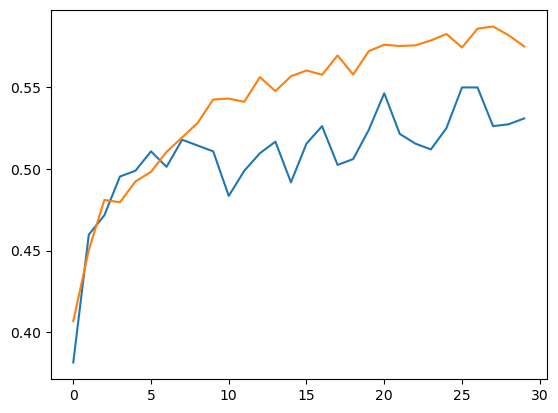

avg_loss 1.0632977996553694
accuracy 0.5237020316027088
Shape of X after subsampling and concatenating: (7616, 22, 75)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 75)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 75])
torch.Size([1, 18, 75])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.60it/s, loss=1.32]


Validation set: Average loss = 1.2748, Accuracy = 0.4159
Training set: Average loss = 1.2556, Accuracy = 0.4395


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.03it/s, loss=1.24]


Validation set: Average loss = 1.2372, Accuracy = 0.4147
Training set: Average loss = 1.2027, Accuracy = 0.4743


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.97it/s, loss=1.29]


Validation set: Average loss = 1.2040, Accuracy = 0.4834
Training set: Average loss = 1.1725, Accuracy = 0.4890


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.41it/s, loss=1.15]


Validation set: Average loss = 1.2040, Accuracy = 0.4609
Training set: Average loss = 1.1468, Accuracy = 0.5114


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.41it/s, loss=1.17]


Validation set: Average loss = 1.1721, Accuracy = 0.4953
Training set: Average loss = 1.1176, Accuracy = 0.5247


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.62it/s, loss=1.23]


Validation set: Average loss = 1.1660, Accuracy = 0.5178
Training set: Average loss = 1.0938, Accuracy = 0.5339


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.90it/s, loss=1.09]


Validation set: Average loss = 1.1333, Accuracy = 0.5178
Training set: Average loss = 1.0722, Accuracy = 0.5491


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.97it/s, loss=1.16]


Validation set: Average loss = 1.1436, Accuracy = 0.5213
Training set: Average loss = 1.0537, Accuracy = 0.5534


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 30.76it/s, loss=1.05]


Validation set: Average loss = 1.1322, Accuracy = 0.5225
Training set: Average loss = 1.0265, Accuracy = 0.5705


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.27it/s, loss=1.23]


Validation set: Average loss = 1.1046, Accuracy = 0.5498
Training set: Average loss = 1.0175, Accuracy = 0.5839


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.08it/s, loss=1.04]


Validation set: Average loss = 1.1108, Accuracy = 0.5201
Training set: Average loss = 1.0026, Accuracy = 0.5989


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.88it/s, loss=1.02]


Validation set: Average loss = 1.0998, Accuracy = 0.5403
Training set: Average loss = 0.9960, Accuracy = 0.5969


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 30.22it/s, loss=1.05]


Validation set: Average loss = 1.1064, Accuracy = 0.5308
Training set: Average loss = 0.9853, Accuracy = 0.5997


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.74it/s, loss=1.08]


Validation set: Average loss = 1.0816, Accuracy = 0.5332
Training set: Average loss = 0.9759, Accuracy = 0.6029


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.93it/s, loss=1.18]


Validation set: Average loss = 1.1089, Accuracy = 0.5462
Training set: Average loss = 0.9708, Accuracy = 0.6041


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.63it/s, loss=0.978]


Validation set: Average loss = 1.0881, Accuracy = 0.5403
Training set: Average loss = 0.9572, Accuracy = 0.6120


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.83it/s, loss=1.05]


Validation set: Average loss = 1.0965, Accuracy = 0.5355
Training set: Average loss = 0.9655, Accuracy = 0.6112


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 29.90it/s, loss=0.898]


Validation set: Average loss = 1.0836, Accuracy = 0.5675
Training set: Average loss = 0.9506, Accuracy = 0.6132


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.30it/s, loss=1.15]


Validation set: Average loss = 1.0728, Accuracy = 0.5533
Training set: Average loss = 0.9430, Accuracy = 0.6196


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.80it/s, loss=0.882]


Validation set: Average loss = 1.0871, Accuracy = 0.5391
Training set: Average loss = 0.9425, Accuracy = 0.6166


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.96it/s, loss=1.03]


Validation set: Average loss = 1.0730, Accuracy = 0.5723
Training set: Average loss = 0.9409, Accuracy = 0.6239


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.74it/s, loss=1.03]


Validation set: Average loss = 1.0781, Accuracy = 0.5533
Training set: Average loss = 0.9406, Accuracy = 0.6261


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.91it/s, loss=1.06]


Validation set: Average loss = 1.0611, Accuracy = 0.5877
Training set: Average loss = 0.9329, Accuracy = 0.6218


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.29it/s, loss=0.875]


Validation set: Average loss = 1.0590, Accuracy = 0.5675
Training set: Average loss = 0.9215, Accuracy = 0.6330


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.35it/s, loss=1.03]


Validation set: Average loss = 1.0765, Accuracy = 0.5533
Training set: Average loss = 0.9205, Accuracy = 0.6258


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.51it/s, loss=0.918]


Validation set: Average loss = 1.0801, Accuracy = 0.5841
Training set: Average loss = 0.9129, Accuracy = 0.6318


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.67it/s, loss=0.968]


Validation set: Average loss = 1.0611, Accuracy = 0.5403
Training set: Average loss = 0.9167, Accuracy = 0.6369


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 29.87it/s, loss=0.923]


Validation set: Average loss = 1.0706, Accuracy = 0.5355
Training set: Average loss = 0.9072, Accuracy = 0.6396


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.87it/s, loss=1.13]


Validation set: Average loss = 1.0487, Accuracy = 0.5723
Training set: Average loss = 0.9045, Accuracy = 0.6431


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.40it/s, loss=0.943]


Validation set: Average loss = 1.0561, Accuracy = 0.5604
Training set: Average loss = 0.9062, Accuracy = 0.6338


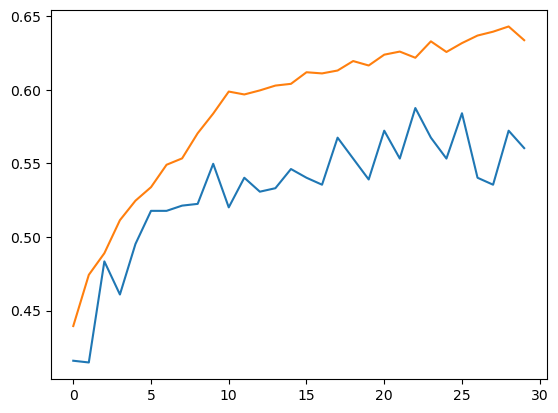

avg_loss 1.0448485357420785
accuracy 0.5485327313769752
Shape of X after subsampling and concatenating: (7616, 22, 100)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 100)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 100])
torch.Size([1, 18, 100])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.38it/s, loss=1.05]


Validation set: Average loss = 1.2495, Accuracy = 0.4076
Training set: Average loss = 1.2020, Accuracy = 0.4769


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.70it/s, loss=1.32]


Validation set: Average loss = 1.1840, Accuracy = 0.4621
Training set: Average loss = 1.1299, Accuracy = 0.5194


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.10it/s, loss=1.05]


Validation set: Average loss = 1.1658, Accuracy = 0.4727
Training set: Average loss = 1.0940, Accuracy = 0.5395


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.08it/s, loss=1.18]


Validation set: Average loss = 1.1448, Accuracy = 0.4964
Training set: Average loss = 1.0665, Accuracy = 0.5639


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.10it/s, loss=1.13]


Validation set: Average loss = 1.1098, Accuracy = 0.5391
Training set: Average loss = 1.0512, Accuracy = 0.5663


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.91it/s, loss=1.14]


Validation set: Average loss = 1.1025, Accuracy = 0.5367
Training set: Average loss = 1.0201, Accuracy = 0.5813


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.17it/s, loss=1.05]


Validation set: Average loss = 1.0973, Accuracy = 0.5201
Training set: Average loss = 1.0219, Accuracy = 0.5780


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.00it/s, loss=1.15]


Validation set: Average loss = 1.1033, Accuracy = 0.5201
Training set: Average loss = 0.9951, Accuracy = 0.6006


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.46it/s, loss=1.04]


Validation set: Average loss = 1.0846, Accuracy = 0.5427
Training set: Average loss = 0.9908, Accuracy = 0.5972


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.09it/s, loss=0.923]


Validation set: Average loss = 1.0709, Accuracy = 0.5675
Training set: Average loss = 0.9697, Accuracy = 0.6116


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.39it/s, loss=1.06]


Validation set: Average loss = 1.0610, Accuracy = 0.5592
Training set: Average loss = 0.9677, Accuracy = 0.6077


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.03it/s, loss=1.15]


Validation set: Average loss = 1.0564, Accuracy = 0.5557
Training set: Average loss = 0.9442, Accuracy = 0.6201


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.42it/s, loss=1.13]


Validation set: Average loss = 1.0380, Accuracy = 0.5557
Training set: Average loss = 0.9391, Accuracy = 0.6220


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.19it/s, loss=1.01]


Validation set: Average loss = 1.0384, Accuracy = 0.5592
Training set: Average loss = 0.9327, Accuracy = 0.6299


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.50it/s, loss=1.09]


Validation set: Average loss = 1.0651, Accuracy = 0.5474
Training set: Average loss = 0.9344, Accuracy = 0.6249


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.98it/s, loss=1.11]


Validation set: Average loss = 1.0271, Accuracy = 0.5770
Training set: Average loss = 0.9142, Accuracy = 0.6406


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.88it/s, loss=1.08]


Validation set: Average loss = 1.0241, Accuracy = 0.5687
Training set: Average loss = 0.9180, Accuracy = 0.6408


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 29.56it/s, loss=1.06]


Validation set: Average loss = 1.0231, Accuracy = 0.5687
Training set: Average loss = 0.8967, Accuracy = 0.6506


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 30.51it/s, loss=1.12]


Validation set: Average loss = 1.0214, Accuracy = 0.5604
Training set: Average loss = 0.9116, Accuracy = 0.6433


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.50it/s, loss=0.807]


Validation set: Average loss = 1.0127, Accuracy = 0.5581
Training set: Average loss = 0.8895, Accuracy = 0.6485


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.23it/s, loss=0.981]


Validation set: Average loss = 1.0210, Accuracy = 0.5628
Training set: Average loss = 0.8873, Accuracy = 0.6597


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.65it/s, loss=1.03]


Validation set: Average loss = 1.0117, Accuracy = 0.5486
Training set: Average loss = 0.8862, Accuracy = 0.6530


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.29it/s, loss=1.09]


Validation set: Average loss = 0.9954, Accuracy = 0.5616
Training set: Average loss = 0.8650, Accuracy = 0.6595


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.32it/s, loss=0.971]


Validation set: Average loss = 1.0010, Accuracy = 0.5782
Training set: Average loss = 0.8645, Accuracy = 0.6657


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.09it/s, loss=0.978]


Validation set: Average loss = 1.0005, Accuracy = 0.5687
Training set: Average loss = 0.8596, Accuracy = 0.6748


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.67it/s, loss=0.893]


Validation set: Average loss = 0.9653, Accuracy = 0.5841
Training set: Average loss = 0.8492, Accuracy = 0.6650


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.72it/s, loss=1.01]


Validation set: Average loss = 0.9941, Accuracy = 0.5758
Training set: Average loss = 0.8522, Accuracy = 0.6761


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.41it/s, loss=1.05]


Validation set: Average loss = 0.9980, Accuracy = 0.5486
Training set: Average loss = 0.8556, Accuracy = 0.6668


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.22it/s, loss=0.988]


Validation set: Average loss = 0.9722, Accuracy = 0.6055
Training set: Average loss = 0.8374, Accuracy = 0.6737


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.95it/s, loss=0.962]


Validation set: Average loss = 0.9728, Accuracy = 0.5652
Training set: Average loss = 0.8265, Accuracy = 0.6850


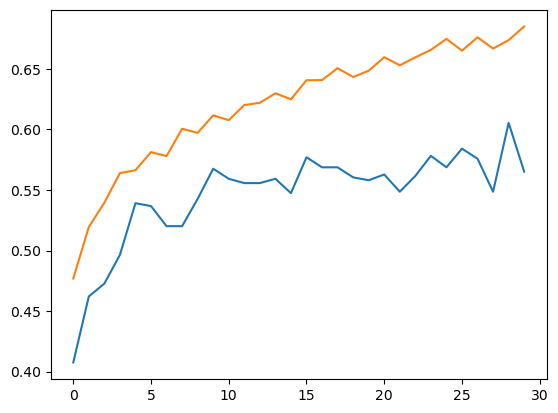

avg_loss 0.9547473788261414
accuracy 0.6162528216704289
Shape of X after subsampling and concatenating: (7616, 22, 125)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 125)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 125])
torch.Size([1, 18, 125])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 24.66it/s, loss=1.18]


Validation set: Average loss = 1.2066, Accuracy = 0.4182
Training set: Average loss = 1.1661, Accuracy = 0.5109


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.03it/s, loss=1.16]


Validation set: Average loss = 1.1218, Accuracy = 0.4775
Training set: Average loss = 1.0742, Accuracy = 0.5624


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 29.69it/s, loss=0.827]


Validation set: Average loss = 1.0825, Accuracy = 0.5059
Training set: Average loss = 1.0230, Accuracy = 0.5953


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.51it/s, loss=0.834]


Validation set: Average loss = 1.0612, Accuracy = 0.5071
Training set: Average loss = 0.9824, Accuracy = 0.6082


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.81it/s, loss=1.02]


Validation set: Average loss = 1.0229, Accuracy = 0.5355
Training set: Average loss = 0.9535, Accuracy = 0.6253


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.34it/s, loss=1.13]


Validation set: Average loss = 0.9975, Accuracy = 0.5581
Training set: Average loss = 0.9171, Accuracy = 0.6387


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.34it/s, loss=0.895]


Validation set: Average loss = 0.9872, Accuracy = 0.5723
Training set: Average loss = 0.8946, Accuracy = 0.6520


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.91it/s, loss=1.01]


Validation set: Average loss = 0.9512, Accuracy = 0.5900
Training set: Average loss = 0.8774, Accuracy = 0.6629


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.24it/s, loss=0.97]


Validation set: Average loss = 0.9528, Accuracy = 0.5818
Training set: Average loss = 0.8553, Accuracy = 0.6658


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.60it/s, loss=0.95]


Validation set: Average loss = 0.9345, Accuracy = 0.5853
Training set: Average loss = 0.8404, Accuracy = 0.6791


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.59it/s, loss=0.863]


Validation set: Average loss = 0.9301, Accuracy = 0.6031
Training set: Average loss = 0.8178, Accuracy = 0.6918


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.95it/s, loss=1.08]


Validation set: Average loss = 0.9077, Accuracy = 0.6126
Training set: Average loss = 0.8003, Accuracy = 0.6930


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 29.38it/s, loss=0.73]


Validation set: Average loss = 0.9089, Accuracy = 0.6078
Training set: Average loss = 0.7944, Accuracy = 0.6950


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.75it/s, loss=0.891]


Validation set: Average loss = 0.8936, Accuracy = 0.6185
Training set: Average loss = 0.7891, Accuracy = 0.7015


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 29.22it/s, loss=0.912]


Validation set: Average loss = 0.8900, Accuracy = 0.6232
Training set: Average loss = 0.7803, Accuracy = 0.7038


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.90it/s, loss=1]


Validation set: Average loss = 0.8902, Accuracy = 0.6244
Training set: Average loss = 0.7745, Accuracy = 0.7068


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 29.77it/s, loss=0.976]


Validation set: Average loss = 0.8773, Accuracy = 0.6363
Training set: Average loss = 0.7656, Accuracy = 0.7111


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.33it/s, loss=0.728]


Validation set: Average loss = 0.8725, Accuracy = 0.6434
Training set: Average loss = 0.7603, Accuracy = 0.7214


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.14it/s, loss=0.888]


Validation set: Average loss = 0.8670, Accuracy = 0.6493
Training set: Average loss = 0.7526, Accuracy = 0.7216


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.93it/s, loss=1.08]


Validation set: Average loss = 0.8653, Accuracy = 0.6505
Training set: Average loss = 0.7443, Accuracy = 0.7233


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.36it/s, loss=0.683]


Validation set: Average loss = 0.8466, Accuracy = 0.6552
Training set: Average loss = 0.7377, Accuracy = 0.7321


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.03it/s, loss=0.914]


Validation set: Average loss = 0.8628, Accuracy = 0.6220
Training set: Average loss = 0.7387, Accuracy = 0.7223


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.89it/s, loss=0.882]


Validation set: Average loss = 0.8528, Accuracy = 0.6469
Training set: Average loss = 0.7324, Accuracy = 0.7300


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.88it/s, loss=0.94]


Validation set: Average loss = 0.8372, Accuracy = 0.6481
Training set: Average loss = 0.7342, Accuracy = 0.7220


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.36it/s, loss=0.768]


Validation set: Average loss = 0.8430, Accuracy = 0.6528
Training set: Average loss = 0.7364, Accuracy = 0.7243


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.34it/s, loss=0.866]


Validation set: Average loss = 0.8250, Accuracy = 0.6777
Training set: Average loss = 0.7160, Accuracy = 0.7379


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.77it/s, loss=0.789]


Validation set: Average loss = 0.8247, Accuracy = 0.6647
Training set: Average loss = 0.7132, Accuracy = 0.7356


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.86it/s, loss=0.91]


Validation set: Average loss = 0.8452, Accuracy = 0.6351
Training set: Average loss = 0.7174, Accuracy = 0.7360


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.54it/s, loss=0.879]


Validation set: Average loss = 0.8234, Accuracy = 0.6659
Training set: Average loss = 0.7106, Accuracy = 0.7426


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.01it/s, loss=0.731]


Validation set: Average loss = 0.8117, Accuracy = 0.6540
Training set: Average loss = 0.7035, Accuracy = 0.7377


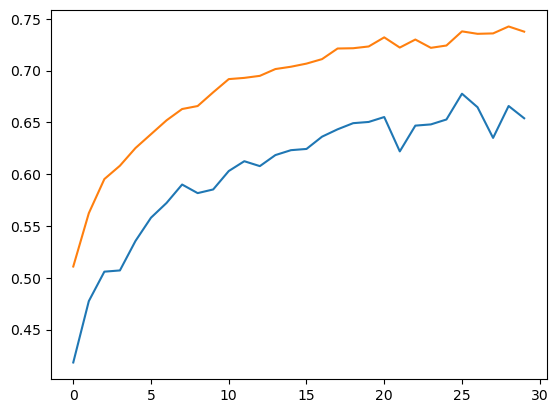

avg_loss 0.8313646912574768
accuracy 0.6681715575620768
Shape of X after subsampling and concatenating: (7616, 22, 150)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 150)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 150])
torch.Size([1, 18, 150])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.60it/s, loss=1.14]


Validation set: Average loss = 1.1926, Accuracy = 0.4609
Training set: Average loss = 1.1556, Accuracy = 0.5102


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.13it/s, loss=1.1]


Validation set: Average loss = 1.1111, Accuracy = 0.4905
Training set: Average loss = 1.0529, Accuracy = 0.5741


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.45it/s, loss=0.823]


Validation set: Average loss = 1.0675, Accuracy = 0.4953
Training set: Average loss = 0.9967, Accuracy = 0.6015


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.85it/s, loss=0.976]


Validation set: Average loss = 1.0342, Accuracy = 0.5474
Training set: Average loss = 0.9609, Accuracy = 0.6203


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.63it/s, loss=0.944]


Validation set: Average loss = 0.9911, Accuracy = 0.5498
Training set: Average loss = 0.9182, Accuracy = 0.6468


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.00it/s, loss=1.07]


Validation set: Average loss = 0.9667, Accuracy = 0.5900
Training set: Average loss = 0.8819, Accuracy = 0.6614


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.07it/s, loss=0.803]


Validation set: Average loss = 0.9504, Accuracy = 0.6232
Training set: Average loss = 0.8552, Accuracy = 0.6738


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.86it/s, loss=0.921]


Validation set: Average loss = 0.9034, Accuracy = 0.6505
Training set: Average loss = 0.8302, Accuracy = 0.6888


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.64it/s, loss=0.925]


Validation set: Average loss = 0.8851, Accuracy = 0.6256
Training set: Average loss = 0.8146, Accuracy = 0.6891


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.11it/s, loss=0.939]


Validation set: Average loss = 0.8925, Accuracy = 0.6256
Training set: Average loss = 0.8126, Accuracy = 0.6858


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.35it/s, loss=0.769]


Validation set: Average loss = 0.8717, Accuracy = 0.6552
Training set: Average loss = 0.7788, Accuracy = 0.7121


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.64it/s, loss=1]


Validation set: Average loss = 0.8598, Accuracy = 0.6600
Training set: Average loss = 0.7660, Accuracy = 0.7206


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.78it/s, loss=0.653]


Validation set: Average loss = 0.8583, Accuracy = 0.6706
Training set: Average loss = 0.7637, Accuracy = 0.7124


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.65it/s, loss=0.843]


Validation set: Average loss = 0.8458, Accuracy = 0.6540
Training set: Average loss = 0.7579, Accuracy = 0.7240


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.20it/s, loss=0.809]


Validation set: Average loss = 0.8392, Accuracy = 0.6564
Training set: Average loss = 0.7534, Accuracy = 0.7181


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.47it/s, loss=1.02]


Validation set: Average loss = 0.8316, Accuracy = 0.6481
Training set: Average loss = 0.7389, Accuracy = 0.7296


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.34it/s, loss=0.97]


Validation set: Average loss = 0.8051, Accuracy = 0.6765
Training set: Average loss = 0.7273, Accuracy = 0.7303


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.93it/s, loss=0.745]


Validation set: Average loss = 0.8096, Accuracy = 0.7026
Training set: Average loss = 0.7235, Accuracy = 0.7426


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.56it/s, loss=0.811]


Validation set: Average loss = 0.8043, Accuracy = 0.7014
Training set: Average loss = 0.7101, Accuracy = 0.7446


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.09it/s, loss=1.12]


Validation set: Average loss = 0.7982, Accuracy = 0.6801
Training set: Average loss = 0.7033, Accuracy = 0.7424


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.91it/s, loss=0.616]


Validation set: Average loss = 0.7831, Accuracy = 0.6931
Training set: Average loss = 0.7026, Accuracy = 0.7463


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.34it/s, loss=0.821]


Validation set: Average loss = 0.8195, Accuracy = 0.6754
Training set: Average loss = 0.7080, Accuracy = 0.7432


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.98it/s, loss=0.857]


Validation set: Average loss = 0.7824, Accuracy = 0.7121
Training set: Average loss = 0.6936, Accuracy = 0.7489


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.78it/s, loss=0.949]


Validation set: Average loss = 0.7760, Accuracy = 0.6908
Training set: Average loss = 0.6936, Accuracy = 0.7442


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.07it/s, loss=0.76]


Validation set: Average loss = 0.7891, Accuracy = 0.6813
Training set: Average loss = 0.6897, Accuracy = 0.7462


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.95it/s, loss=0.85]


Validation set: Average loss = 0.7768, Accuracy = 0.7026
Training set: Average loss = 0.6776, Accuracy = 0.7629


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.32it/s, loss=0.685]


Validation set: Average loss = 0.7759, Accuracy = 0.7038
Training set: Average loss = 0.6702, Accuracy = 0.7613


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.44it/s, loss=0.719]


Validation set: Average loss = 0.7641, Accuracy = 0.7156
Training set: Average loss = 0.6673, Accuracy = 0.7592


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.82it/s, loss=0.855]


Validation set: Average loss = 0.7592, Accuracy = 0.7026
Training set: Average loss = 0.6649, Accuracy = 0.7591


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.64it/s, loss=0.748]


Validation set: Average loss = 0.7554, Accuracy = 0.7062
Training set: Average loss = 0.6580, Accuracy = 0.7625


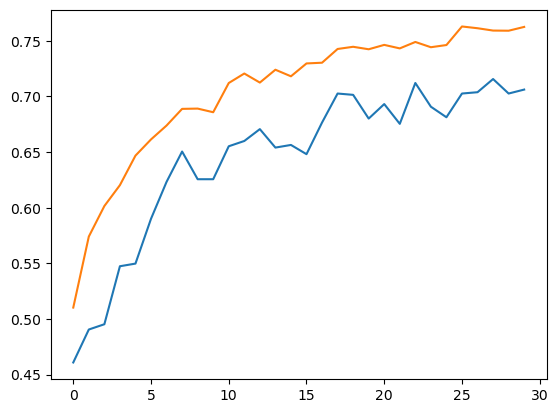

avg_loss 0.8137680888175964
accuracy 0.6704288939051919
Shape of X after subsampling and concatenating: (7616, 22, 175)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 175)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 175])
torch.Size([1, 18, 175])


Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.25it/s, loss=1.2]


Validation set: Average loss = 1.1733, Accuracy = 0.4656
Training set: Average loss = 1.1046, Accuracy = 0.5533


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.07it/s, loss=1.03]


Validation set: Average loss = 1.0977, Accuracy = 0.4953
Training set: Average loss = 0.9964, Accuracy = 0.5986


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.93it/s, loss=1.03]


Validation set: Average loss = 1.0584, Accuracy = 0.5308
Training set: Average loss = 0.9325, Accuracy = 0.6182


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 23.86it/s, loss=0.97]


Validation set: Average loss = 1.0357, Accuracy = 0.5545
Training set: Average loss = 0.8864, Accuracy = 0.6653


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.06it/s, loss=0.975]


Validation set: Average loss = 0.9912, Accuracy = 0.6066
Training set: Average loss = 0.8608, Accuracy = 0.6584


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.55it/s, loss=0.89]


Validation set: Average loss = 0.9572, Accuracy = 0.6315
Training set: Average loss = 0.8441, Accuracy = 0.6711


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.78it/s, loss=0.996]


Validation set: Average loss = 0.9879, Accuracy = 0.6114
Training set: Average loss = 0.8206, Accuracy = 0.6702


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.68it/s, loss=1.07]


Validation set: Average loss = 0.9558, Accuracy = 0.5995
Training set: Average loss = 0.7879, Accuracy = 0.7008


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.06it/s, loss=1.03]


Validation set: Average loss = 0.9411, Accuracy = 0.6398
Training set: Average loss = 0.7769, Accuracy = 0.6996


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.15it/s, loss=0.983]


Validation set: Average loss = 0.9279, Accuracy = 0.6374
Training set: Average loss = 0.7615, Accuracy = 0.7096


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.51it/s, loss=0.908]


Validation set: Average loss = 0.9243, Accuracy = 0.6374
Training set: Average loss = 0.7527, Accuracy = 0.7128


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 19.86it/s, loss=0.856]


Validation set: Average loss = 0.9007, Accuracy = 0.6434
Training set: Average loss = 0.7382, Accuracy = 0.7258


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.40it/s, loss=0.94]


Validation set: Average loss = 0.8933, Accuracy = 0.6635
Training set: Average loss = 0.7392, Accuracy = 0.7257


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.25it/s, loss=0.786]


Validation set: Average loss = 0.8689, Accuracy = 0.6386
Training set: Average loss = 0.7156, Accuracy = 0.7307


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.79it/s, loss=0.768]


Validation set: Average loss = 0.8636, Accuracy = 0.6694
Training set: Average loss = 0.7166, Accuracy = 0.7433


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.57it/s, loss=0.91]


Validation set: Average loss = 0.8652, Accuracy = 0.6434
Training set: Average loss = 0.6989, Accuracy = 0.7423


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.75it/s, loss=1.02]


Validation set: Average loss = 0.8733, Accuracy = 0.6422
Training set: Average loss = 0.6997, Accuracy = 0.7446


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.79it/s, loss=0.857]


Validation set: Average loss = 0.8561, Accuracy = 0.6671
Training set: Average loss = 0.7001, Accuracy = 0.7311


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.35it/s, loss=0.795]


Validation set: Average loss = 0.8535, Accuracy = 0.6742
Training set: Average loss = 0.6898, Accuracy = 0.7417


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.83it/s, loss=0.821]


Validation set: Average loss = 0.8337, Accuracy = 0.6611
Training set: Average loss = 0.6719, Accuracy = 0.7526


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.02it/s, loss=0.771]


Validation set: Average loss = 0.8478, Accuracy = 0.6588
Training set: Average loss = 0.6727, Accuracy = 0.7436


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.89it/s, loss=0.783]


Validation set: Average loss = 0.8323, Accuracy = 0.6564
Training set: Average loss = 0.6615, Accuracy = 0.7543


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.92it/s, loss=0.685]


Validation set: Average loss = 0.8265, Accuracy = 0.6682
Training set: Average loss = 0.6648, Accuracy = 0.7492


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.00it/s, loss=0.714]


Validation set: Average loss = 0.8190, Accuracy = 0.6718
Training set: Average loss = 0.6514, Accuracy = 0.7669


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.24it/s, loss=0.813]


Validation set: Average loss = 0.8216, Accuracy = 0.6742
Training set: Average loss = 0.6587, Accuracy = 0.7538


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.01it/s, loss=0.802]


Validation set: Average loss = 0.8078, Accuracy = 0.6813
Training set: Average loss = 0.6348, Accuracy = 0.7640


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.61it/s, loss=0.547]


Validation set: Average loss = 0.8134, Accuracy = 0.6623
Training set: Average loss = 0.6411, Accuracy = 0.7623


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.90it/s, loss=0.699]


Validation set: Average loss = 0.7980, Accuracy = 0.6825
Training set: Average loss = 0.6308, Accuracy = 0.7727


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 27.86it/s, loss=0.716]


Validation set: Average loss = 0.8100, Accuracy = 0.6860
Training set: Average loss = 0.6311, Accuracy = 0.7684


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 28.72it/s, loss=0.812]


Validation set: Average loss = 0.7972, Accuracy = 0.6694
Training set: Average loss = 0.6278, Accuracy = 0.7672


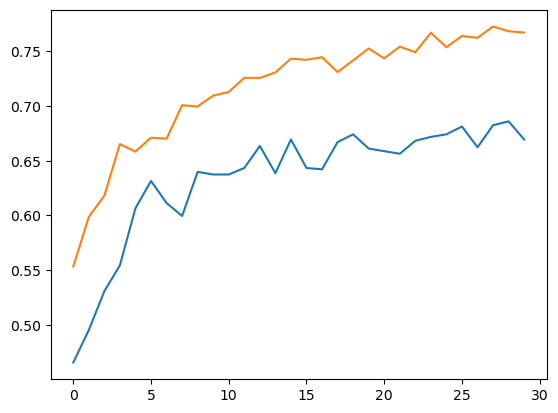

avg_loss 0.8231862953730992
accuracy 0.6862302483069977
Shape of X after subsampling and concatenating: (7616, 22, 200)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 200)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 200])
torch.Size([1, 18, 200])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 26.77it/s, loss=1.24]


Validation set: Average loss = 1.1480, Accuracy = 0.4882
Training set: Average loss = 1.0742, Accuracy = 0.5607


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.42it/s, loss=1.12]


Validation set: Average loss = 1.0574, Accuracy = 0.5545
Training set: Average loss = 0.9808, Accuracy = 0.6092


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.42it/s, loss=1.03]


Validation set: Average loss = 0.9934, Accuracy = 0.6066
Training set: Average loss = 0.9100, Accuracy = 0.6414


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.16it/s, loss=1.02]


Validation set: Average loss = 0.9806, Accuracy = 0.6078
Training set: Average loss = 0.8810, Accuracy = 0.6524


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 24.90it/s, loss=0.93]


Validation set: Average loss = 0.9638, Accuracy = 0.5841
Training set: Average loss = 0.8528, Accuracy = 0.6644


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.51it/s, loss=0.93]


Validation set: Average loss = 0.9316, Accuracy = 0.6493
Training set: Average loss = 0.8224, Accuracy = 0.6796


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.91it/s, loss=1.09]


Validation set: Average loss = 0.8942, Accuracy = 0.6611
Training set: Average loss = 0.7884, Accuracy = 0.7026


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.27it/s, loss=0.916]


Validation set: Average loss = 0.8913, Accuracy = 0.6528
Training set: Average loss = 0.7778, Accuracy = 0.7029


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.52it/s, loss=0.951]


Validation set: Average loss = 0.8508, Accuracy = 0.6931
Training set: Average loss = 0.7537, Accuracy = 0.7156


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.00it/s, loss=0.717]


Validation set: Average loss = 0.8378, Accuracy = 0.7073
Training set: Average loss = 0.7331, Accuracy = 0.7286


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.55it/s, loss=1.02]


Validation set: Average loss = 0.8156, Accuracy = 0.7204
Training set: Average loss = 0.7250, Accuracy = 0.7277


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.37it/s, loss=0.86]


Validation set: Average loss = 0.8040, Accuracy = 0.7085
Training set: Average loss = 0.7060, Accuracy = 0.7352


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.86it/s, loss=0.967]


Validation set: Average loss = 0.8160, Accuracy = 0.6848
Training set: Average loss = 0.7114, Accuracy = 0.7316


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.54it/s, loss=0.737]


Validation set: Average loss = 0.7862, Accuracy = 0.7062
Training set: Average loss = 0.6920, Accuracy = 0.7465


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.50it/s, loss=0.832]


Validation set: Average loss = 0.7820, Accuracy = 0.7050
Training set: Average loss = 0.6790, Accuracy = 0.7553


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.53it/s, loss=0.779]


Validation set: Average loss = 0.7862, Accuracy = 0.7014
Training set: Average loss = 0.6741, Accuracy = 0.7488


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.35it/s, loss=1.13]


Validation set: Average loss = 0.7726, Accuracy = 0.7227
Training set: Average loss = 0.6618, Accuracy = 0.7623


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.03it/s, loss=0.724]


Validation set: Average loss = 0.7573, Accuracy = 0.7002
Training set: Average loss = 0.6622, Accuracy = 0.7608


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.51it/s, loss=0.733]


Validation set: Average loss = 0.7592, Accuracy = 0.7216
Training set: Average loss = 0.6466, Accuracy = 0.7635


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 24.59it/s, loss=0.632]


Validation set: Average loss = 0.7555, Accuracy = 0.7168
Training set: Average loss = 0.6421, Accuracy = 0.7614


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.19it/s, loss=1.06]


Validation set: Average loss = 0.7408, Accuracy = 0.7227
Training set: Average loss = 0.6278, Accuracy = 0.7809


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.66it/s, loss=0.833]


Validation set: Average loss = 0.7514, Accuracy = 0.7180
Training set: Average loss = 0.6283, Accuracy = 0.7760


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.53it/s, loss=0.945]


Validation set: Average loss = 0.7564, Accuracy = 0.7204
Training set: Average loss = 0.6282, Accuracy = 0.7719


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 22.05it/s, loss=0.692]


Validation set: Average loss = 0.7478, Accuracy = 0.7287
Training set: Average loss = 0.6208, Accuracy = 0.7744


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.47it/s, loss=0.868]


Validation set: Average loss = 0.7343, Accuracy = 0.7204
Training set: Average loss = 0.6173, Accuracy = 0.7812


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.72it/s, loss=0.729]


Validation set: Average loss = 0.7368, Accuracy = 0.7121
Training set: Average loss = 0.6062, Accuracy = 0.7831


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.20it/s, loss=0.666]


Validation set: Average loss = 0.7196, Accuracy = 0.7346
Training set: Average loss = 0.6058, Accuracy = 0.7822


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.72it/s, loss=0.837]


Validation set: Average loss = 0.7603, Accuracy = 0.6979
Training set: Average loss = 0.6127, Accuracy = 0.7715


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.61it/s, loss=0.761]


Validation set: Average loss = 0.7156, Accuracy = 0.7275
Training set: Average loss = 0.5929, Accuracy = 0.7897


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 14.99it/s, loss=0.884]


Validation set: Average loss = 0.7145, Accuracy = 0.7299
Training set: Average loss = 0.6025, Accuracy = 0.7761


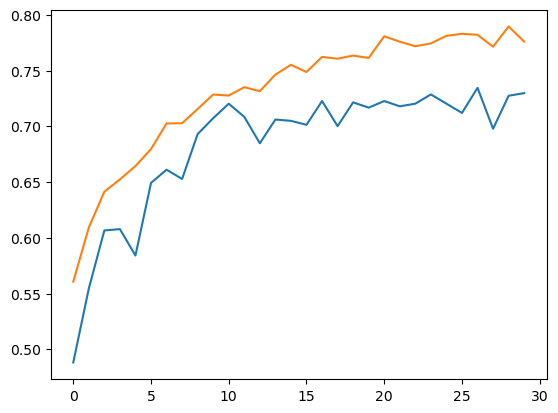

avg_loss 0.7750040973935809
accuracy 0.7110609480812641
Shape of X after subsampling and concatenating: (7616, 22, 225)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 225)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 225])
torch.Size([1, 18, 225])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.81it/s, loss=1.08]


Validation set: Average loss = 1.0754, Accuracy = 0.5545
Training set: Average loss = 1.0386, Accuracy = 0.5683


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.05it/s, loss=1.11]


Validation set: Average loss = 1.0252, Accuracy = 0.6019
Training set: Average loss = 0.9431, Accuracy = 0.6329


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.53it/s, loss=0.992]


Validation set: Average loss = 0.9597, Accuracy = 0.6256
Training set: Average loss = 0.8703, Accuracy = 0.6614


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.78it/s, loss=0.903]


Validation set: Average loss = 0.9245, Accuracy = 0.6268
Training set: Average loss = 0.8191, Accuracy = 0.6912


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.59it/s, loss=0.947]


Validation set: Average loss = 0.8874, Accuracy = 0.6528
Training set: Average loss = 0.7827, Accuracy = 0.7048


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.27it/s, loss=0.755]


Validation set: Average loss = 0.8720, Accuracy = 0.6457
Training set: Average loss = 0.7689, Accuracy = 0.7106


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.57it/s, loss=0.666]


Validation set: Average loss = 0.8355, Accuracy = 0.6706
Training set: Average loss = 0.7303, Accuracy = 0.7253


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 23.85it/s, loss=0.849]


Validation set: Average loss = 0.8155, Accuracy = 0.6564
Training set: Average loss = 0.7112, Accuracy = 0.7353


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.13it/s, loss=0.935]


Validation set: Average loss = 0.8024, Accuracy = 0.6836
Training set: Average loss = 0.6988, Accuracy = 0.7467


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.55it/s, loss=0.976]


Validation set: Average loss = 0.7732, Accuracy = 0.6872
Training set: Average loss = 0.6985, Accuracy = 0.7419


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.29it/s, loss=0.802]


Validation set: Average loss = 0.8005, Accuracy = 0.6801
Training set: Average loss = 0.6886, Accuracy = 0.7413


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 20.27it/s, loss=0.737]


Validation set: Average loss = 0.7663, Accuracy = 0.7014
Training set: Average loss = 0.6725, Accuracy = 0.7457


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.08it/s, loss=0.862]


Validation set: Average loss = 0.7554, Accuracy = 0.7073
Training set: Average loss = 0.6584, Accuracy = 0.7648


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.58it/s, loss=0.739]


Validation set: Average loss = 0.7604, Accuracy = 0.7121
Training set: Average loss = 0.6501, Accuracy = 0.7660


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.89it/s, loss=0.884]


Validation set: Average loss = 0.7545, Accuracy = 0.7050
Training set: Average loss = 0.6485, Accuracy = 0.7673


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.55it/s, loss=0.623]


Validation set: Average loss = 0.7363, Accuracy = 0.7133
Training set: Average loss = 0.6291, Accuracy = 0.7706


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.02it/s, loss=0.902]


Validation set: Average loss = 0.7424, Accuracy = 0.7109
Training set: Average loss = 0.6266, Accuracy = 0.7739


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.06it/s, loss=0.776]


Validation set: Average loss = 0.7574, Accuracy = 0.7073
Training set: Average loss = 0.6369, Accuracy = 0.7616


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.84it/s, loss=0.772]


Validation set: Average loss = 0.7339, Accuracy = 0.7275
Training set: Average loss = 0.6213, Accuracy = 0.7845


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.43it/s, loss=0.561]


Validation set: Average loss = 0.7235, Accuracy = 0.7239
Training set: Average loss = 0.6058, Accuracy = 0.7877


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.61it/s, loss=0.719]


Validation set: Average loss = 0.7308, Accuracy = 0.7192
Training set: Average loss = 0.6039, Accuracy = 0.7881


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.01it/s, loss=0.819]


Validation set: Average loss = 0.7212, Accuracy = 0.7109
Training set: Average loss = 0.6045, Accuracy = 0.7816


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.45it/s, loss=0.546]


Validation set: Average loss = 0.7353, Accuracy = 0.7204
Training set: Average loss = 0.5961, Accuracy = 0.7908


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.79it/s, loss=0.731]


Validation set: Average loss = 0.7273, Accuracy = 0.7145
Training set: Average loss = 0.5958, Accuracy = 0.7879


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.42it/s, loss=0.583]


Validation set: Average loss = 0.7094, Accuracy = 0.7168
Training set: Average loss = 0.5865, Accuracy = 0.7948


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.60it/s, loss=0.629]


Validation set: Average loss = 0.7396, Accuracy = 0.7038
Training set: Average loss = 0.5939, Accuracy = 0.7864


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00,  9.99it/s, loss=0.758]


Validation set: Average loss = 0.7213, Accuracy = 0.7156
Training set: Average loss = 0.5809, Accuracy = 0.7969


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.71it/s, loss=0.551]


Validation set: Average loss = 0.7004, Accuracy = 0.7192
Training set: Average loss = 0.5747, Accuracy = 0.7957


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.42it/s, loss=0.853]


Validation set: Average loss = 0.7139, Accuracy = 0.7109
Training set: Average loss = 0.5616, Accuracy = 0.8041


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.01it/s, loss=0.705]


Validation set: Average loss = 0.6953, Accuracy = 0.7145
Training set: Average loss = 0.5611, Accuracy = 0.8044


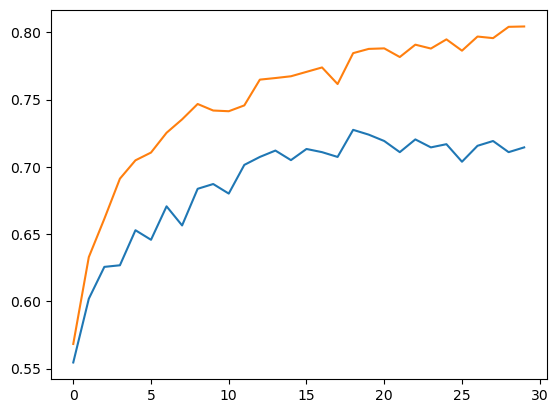

avg_loss 0.7799548421587262
accuracy 0.7155756207674944
Shape of X after subsampling and concatenating: (7616, 22, 250)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 250)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 250])
torch.Size([1, 18, 250])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.98it/s, loss=1.09]


Validation set: Average loss = 1.0545, Accuracy = 0.5746
Training set: Average loss = 1.0255, Accuracy = 0.5815


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.65it/s, loss=1.02]


Validation set: Average loss = 1.0044, Accuracy = 0.6066
Training set: Average loss = 0.9252, Accuracy = 0.6438


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.17it/s, loss=0.907]


Validation set: Average loss = 0.9580, Accuracy = 0.6197
Training set: Average loss = 0.8601, Accuracy = 0.6720


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.46it/s, loss=0.897]


Validation set: Average loss = 0.9118, Accuracy = 0.6280
Training set: Average loss = 0.8086, Accuracy = 0.7001


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.54it/s, loss=0.966]


Validation set: Average loss = 0.8798, Accuracy = 0.6540
Training set: Average loss = 0.7732, Accuracy = 0.7155


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.99it/s, loss=0.75]


Validation set: Average loss = 0.8614, Accuracy = 0.6363
Training set: Average loss = 0.7581, Accuracy = 0.7210


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.03it/s, loss=0.648]


Validation set: Average loss = 0.8473, Accuracy = 0.6469
Training set: Average loss = 0.7252, Accuracy = 0.7258


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.71it/s, loss=0.897]


Validation set: Average loss = 0.7980, Accuracy = 0.6872
Training set: Average loss = 0.7022, Accuracy = 0.7453


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.79it/s, loss=0.857]


Validation set: Average loss = 0.7871, Accuracy = 0.6872
Training set: Average loss = 0.6864, Accuracy = 0.7571


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.85it/s, loss=0.885]


Validation set: Average loss = 0.7564, Accuracy = 0.7073
Training set: Average loss = 0.6774, Accuracy = 0.7551


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.00it/s, loss=0.773]


Validation set: Average loss = 0.8012, Accuracy = 0.6991
Training set: Average loss = 0.6769, Accuracy = 0.7504


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.60it/s, loss=0.651]


Validation set: Average loss = 0.7582, Accuracy = 0.7133
Training set: Average loss = 0.6647, Accuracy = 0.7559


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.04it/s, loss=0.862]


Validation set: Average loss = 0.7485, Accuracy = 0.7073
Training set: Average loss = 0.6458, Accuracy = 0.7681


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.29it/s, loss=0.77]


Validation set: Average loss = 0.7492, Accuracy = 0.7192
Training set: Average loss = 0.6362, Accuracy = 0.7773


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.65it/s, loss=0.851]


Validation set: Average loss = 0.7433, Accuracy = 0.7204
Training set: Average loss = 0.6349, Accuracy = 0.7688


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.13it/s, loss=0.63]


Validation set: Average loss = 0.7327, Accuracy = 0.7168
Training set: Average loss = 0.6165, Accuracy = 0.7802


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 23.23it/s, loss=0.966]


Validation set: Average loss = 0.7243, Accuracy = 0.7263
Training set: Average loss = 0.6085, Accuracy = 0.7834


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.63it/s, loss=0.849]


Validation set: Average loss = 0.7453, Accuracy = 0.7216
Training set: Average loss = 0.6125, Accuracy = 0.7802


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:05<00:00, 21.82it/s, loss=0.752]


Validation set: Average loss = 0.7565, Accuracy = 0.7133
Training set: Average loss = 0.6178, Accuracy = 0.7777


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.41it/s, loss=0.586]


Validation set: Average loss = 0.7348, Accuracy = 0.7239
Training set: Average loss = 0.6096, Accuracy = 0.7814


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.78it/s, loss=0.724]


Validation set: Average loss = 0.7339, Accuracy = 0.7239
Training set: Average loss = 0.5951, Accuracy = 0.7919


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.13it/s, loss=0.679]


Validation set: Average loss = 0.7412, Accuracy = 0.7038
Training set: Average loss = 0.5992, Accuracy = 0.7876


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.03it/s, loss=0.568]


Validation set: Average loss = 0.7240, Accuracy = 0.7346
Training set: Average loss = 0.5853, Accuracy = 0.7992


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.71it/s, loss=0.723]


Validation set: Average loss = 0.7101, Accuracy = 0.7358
Training set: Average loss = 0.5733, Accuracy = 0.8008


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.99it/s, loss=0.535]


Validation set: Average loss = 0.7127, Accuracy = 0.7038
Training set: Average loss = 0.5813, Accuracy = 0.7902


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.40it/s, loss=0.573]


Validation set: Average loss = 0.7458, Accuracy = 0.7002
Training set: Average loss = 0.5946, Accuracy = 0.7837


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.22it/s, loss=0.761]


Validation set: Average loss = 0.7243, Accuracy = 0.7133
Training set: Average loss = 0.5700, Accuracy = 0.8042


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.21it/s, loss=0.634]


Validation set: Average loss = 0.7120, Accuracy = 0.7204
Training set: Average loss = 0.5611, Accuracy = 0.8049


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.36it/s, loss=0.716]


Validation set: Average loss = 0.6917, Accuracy = 0.7192
Training set: Average loss = 0.5568, Accuracy = 0.8055


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.31it/s, loss=0.828]


Validation set: Average loss = 0.7019, Accuracy = 0.7263
Training set: Average loss = 0.5579, Accuracy = 0.7985


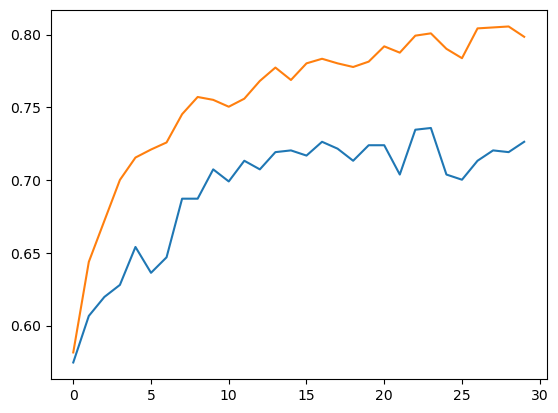

avg_loss 0.7675879512514386
accuracy 0.6839729119638827
Shape of X after subsampling and concatenating: (7616, 22, 275)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 275)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 275])
torch.Size([1, 18, 275])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.87it/s, loss=1.37]


Validation set: Average loss = 1.1330, Accuracy = 0.5249
Training set: Average loss = 1.0469, Accuracy = 0.5723


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.42it/s, loss=1.09]


Validation set: Average loss = 1.0394, Accuracy = 0.5687
Training set: Average loss = 0.9236, Accuracy = 0.6410


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.15it/s, loss=1.02]


Validation set: Average loss = 1.0047, Accuracy = 0.5818
Training set: Average loss = 0.8633, Accuracy = 0.6740


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.67it/s, loss=0.884]


Validation set: Average loss = 0.9528, Accuracy = 0.6351
Training set: Average loss = 0.8172, Accuracy = 0.6922


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.80it/s, loss=1.01]


Validation set: Average loss = 0.9442, Accuracy = 0.6327
Training set: Average loss = 0.7883, Accuracy = 0.7077


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.74it/s, loss=0.842]


Validation set: Average loss = 0.9083, Accuracy = 0.6671
Training set: Average loss = 0.7460, Accuracy = 0.7252


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.02it/s, loss=0.826]


Validation set: Average loss = 0.8780, Accuracy = 0.6694
Training set: Average loss = 0.7208, Accuracy = 0.7411


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.91it/s, loss=0.693]


Validation set: Average loss = 0.8257, Accuracy = 0.7062
Training set: Average loss = 0.6909, Accuracy = 0.7571


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.17it/s, loss=0.89]


Validation set: Average loss = 0.8264, Accuracy = 0.6754
Training set: Average loss = 0.6904, Accuracy = 0.7493


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.62it/s, loss=0.912]


Validation set: Average loss = 0.7945, Accuracy = 0.7002
Training set: Average loss = 0.6649, Accuracy = 0.7626


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.53it/s, loss=0.831]


Validation set: Average loss = 0.7659, Accuracy = 0.7239
Training set: Average loss = 0.6362, Accuracy = 0.7802


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.14it/s, loss=0.889]


Validation set: Average loss = 0.7651, Accuracy = 0.6991
Training set: Average loss = 0.6408, Accuracy = 0.7713


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.82it/s, loss=0.713]


Validation set: Average loss = 0.7348, Accuracy = 0.7192
Training set: Average loss = 0.6331, Accuracy = 0.7789


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.11it/s, loss=0.764]


Validation set: Average loss = 0.7646, Accuracy = 0.7109
Training set: Average loss = 0.6208, Accuracy = 0.7811


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.97it/s, loss=0.741]


Validation set: Average loss = 0.7553, Accuracy = 0.7251
Training set: Average loss = 0.6046, Accuracy = 0.7916


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.57it/s, loss=1.07]


Validation set: Average loss = 0.7168, Accuracy = 0.7370
Training set: Average loss = 0.5946, Accuracy = 0.7931


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.84it/s, loss=0.68]


Validation set: Average loss = 0.6930, Accuracy = 0.7547
Training set: Average loss = 0.5773, Accuracy = 0.8015


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.30it/s, loss=0.753]


Validation set: Average loss = 0.6968, Accuracy = 0.7559
Training set: Average loss = 0.5848, Accuracy = 0.8012


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.80it/s, loss=0.793]


Validation set: Average loss = 0.6960, Accuracy = 0.7405
Training set: Average loss = 0.5749, Accuracy = 0.7987


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.58it/s, loss=0.936]


Validation set: Average loss = 0.6812, Accuracy = 0.7512
Training set: Average loss = 0.5669, Accuracy = 0.7958


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.58it/s, loss=0.83]


Validation set: Average loss = 0.6780, Accuracy = 0.7310
Training set: Average loss = 0.5699, Accuracy = 0.8000


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.66it/s, loss=0.656]


Validation set: Average loss = 0.6663, Accuracy = 0.7429
Training set: Average loss = 0.5547, Accuracy = 0.8125


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.46it/s, loss=0.478]


Validation set: Average loss = 0.6558, Accuracy = 0.7417
Training set: Average loss = 0.5497, Accuracy = 0.8105


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.57it/s, loss=0.741]


Validation set: Average loss = 0.6644, Accuracy = 0.7488
Training set: Average loss = 0.5535, Accuracy = 0.8088


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.81it/s, loss=0.71]


Validation set: Average loss = 0.6563, Accuracy = 0.7417
Training set: Average loss = 0.5389, Accuracy = 0.8118


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.71it/s, loss=0.596]


Validation set: Average loss = 0.6735, Accuracy = 0.7441
Training set: Average loss = 0.5397, Accuracy = 0.8136


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.06it/s, loss=0.728]


Validation set: Average loss = 0.6589, Accuracy = 0.7441
Training set: Average loss = 0.5230, Accuracy = 0.8189


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.38it/s, loss=0.637]


Validation set: Average loss = 0.6618, Accuracy = 0.7417
Training set: Average loss = 0.5305, Accuracy = 0.8107


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.82it/s, loss=0.506]


Validation set: Average loss = 0.6773, Accuracy = 0.7429
Training set: Average loss = 0.5304, Accuracy = 0.8084


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 11.91it/s, loss=0.681]


Validation set: Average loss = 0.6407, Accuracy = 0.7453
Training set: Average loss = 0.5122, Accuracy = 0.8239


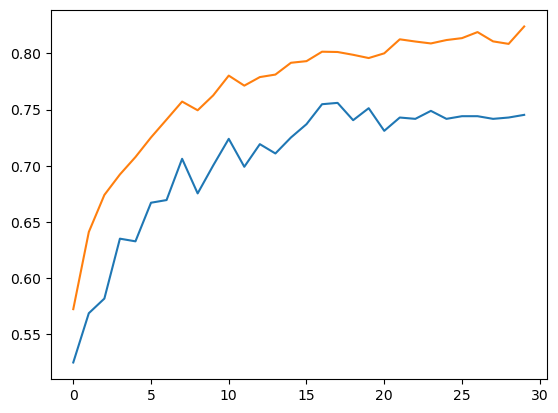

avg_loss 0.7312236513410296
accuracy 0.6975169300225733
Shape of X after subsampling and concatenating: (7616, 22, 300)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 300)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 300])
torch.Size([1, 18, 300])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.46it/s, loss=1.22]


Validation set: Average loss = 1.1264, Accuracy = 0.5308
Training set: Average loss = 1.0362, Accuracy = 0.5903


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.99it/s, loss=0.978]


Validation set: Average loss = 1.0215, Accuracy = 0.5746
Training set: Average loss = 0.9055, Accuracy = 0.6560


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.30it/s, loss=0.948]


Validation set: Average loss = 0.9924, Accuracy = 0.5960
Training set: Average loss = 0.8470, Accuracy = 0.6735


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.10it/s, loss=0.789]


Validation set: Average loss = 0.9711, Accuracy = 0.5829
Training set: Average loss = 0.8119, Accuracy = 0.6951


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.30it/s, loss=0.798]


Validation set: Average loss = 0.9375, Accuracy = 0.6090
Training set: Average loss = 0.7738, Accuracy = 0.7109


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.86it/s, loss=0.767]


Validation set: Average loss = 0.8848, Accuracy = 0.6600
Training set: Average loss = 0.7301, Accuracy = 0.7312


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.09it/s, loss=0.959]


Validation set: Average loss = 0.8580, Accuracy = 0.6718
Training set: Average loss = 0.6914, Accuracy = 0.7505


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.93it/s, loss=0.961]


Validation set: Average loss = 0.8285, Accuracy = 0.6955
Training set: Average loss = 0.6613, Accuracy = 0.7642


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.87it/s, loss=0.676]


Validation set: Average loss = 0.8220, Accuracy = 0.6706
Training set: Average loss = 0.6510, Accuracy = 0.7638


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.21it/s, loss=0.996]


Validation set: Average loss = 0.7889, Accuracy = 0.7062
Training set: Average loss = 0.6150, Accuracy = 0.7832


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.84it/s, loss=0.758]


Validation set: Average loss = 0.7609, Accuracy = 0.7263
Training set: Average loss = 0.6018, Accuracy = 0.7899


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.33it/s, loss=0.659]


Validation set: Average loss = 0.7403, Accuracy = 0.7334
Training set: Average loss = 0.6008, Accuracy = 0.7894


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.23it/s, loss=0.743]


Validation set: Average loss = 0.7303, Accuracy = 0.7322
Training set: Average loss = 0.5825, Accuracy = 0.7978


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.56it/s, loss=0.713]


Validation set: Average loss = 0.7288, Accuracy = 0.7322
Training set: Average loss = 0.5819, Accuracy = 0.7914


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.71it/s, loss=0.744]


Validation set: Average loss = 0.7329, Accuracy = 0.7263
Training set: Average loss = 0.5820, Accuracy = 0.7954


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 17.25it/s, loss=0.753]


Validation set: Average loss = 0.7384, Accuracy = 0.7121
Training set: Average loss = 0.5874, Accuracy = 0.7870


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.03it/s, loss=0.899]


Validation set: Average loss = 0.7004, Accuracy = 0.7405
Training set: Average loss = 0.5676, Accuracy = 0.8008


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.55it/s, loss=0.694]


Validation set: Average loss = 0.7054, Accuracy = 0.7263
Training set: Average loss = 0.5679, Accuracy = 0.7924


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 18.53it/s, loss=0.621]


Validation set: Average loss = 0.7036, Accuracy = 0.7370
Training set: Average loss = 0.5443, Accuracy = 0.8088


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.13it/s, loss=0.941]


Validation set: Average loss = 0.6872, Accuracy = 0.7370
Training set: Average loss = 0.5457, Accuracy = 0.8065


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.06it/s, loss=0.567]


Validation set: Average loss = 0.6808, Accuracy = 0.7761
Training set: Average loss = 0.5378, Accuracy = 0.8196


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.43it/s, loss=0.821]


Validation set: Average loss = 0.6615, Accuracy = 0.7512
Training set: Average loss = 0.5292, Accuracy = 0.8162


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.44it/s, loss=0.717]


Validation set: Average loss = 0.6543, Accuracy = 0.7618
Training set: Average loss = 0.5274, Accuracy = 0.8181


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.49it/s, loss=0.72]


Validation set: Average loss = 0.6569, Accuracy = 0.7630
Training set: Average loss = 0.5206, Accuracy = 0.8163


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.59it/s, loss=0.615]


Validation set: Average loss = 0.6615, Accuracy = 0.7500
Training set: Average loss = 0.5129, Accuracy = 0.8265


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.644]


Validation set: Average loss = 0.6556, Accuracy = 0.7595
Training set: Average loss = 0.5153, Accuracy = 0.8212


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.15it/s, loss=0.709]


Validation set: Average loss = 0.6411, Accuracy = 0.7654
Training set: Average loss = 0.5124, Accuracy = 0.8246


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.05it/s, loss=0.523]


Validation set: Average loss = 0.6328, Accuracy = 0.7796
Training set: Average loss = 0.5037, Accuracy = 0.8292


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.695]


Validation set: Average loss = 0.6361, Accuracy = 0.7784
Training set: Average loss = 0.5040, Accuracy = 0.8241


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.71it/s, loss=0.554]


Validation set: Average loss = 0.6304, Accuracy = 0.7678
Training set: Average loss = 0.5139, Accuracy = 0.8220


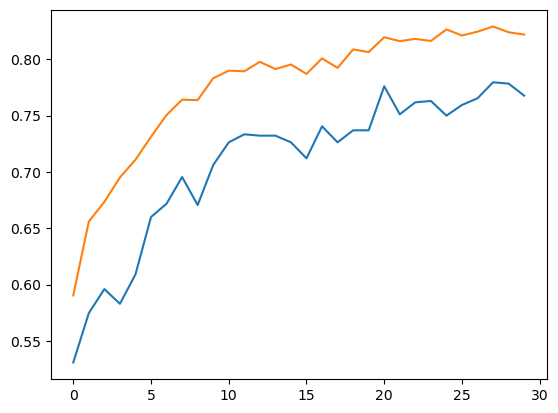

avg_loss 0.7892175827707563
accuracy 0.6839729119638827
Shape of X after subsampling and concatenating: (7616, 22, 325)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 325)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 325])
torch.Size([1, 18, 325])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.43it/s, loss=1.04]


Validation set: Average loss = 1.1449, Accuracy = 0.5213
Training set: Average loss = 1.0472, Accuracy = 0.5737


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.60it/s, loss=0.933]


Validation set: Average loss = 1.0188, Accuracy = 0.5427
Training set: Average loss = 0.9095, Accuracy = 0.6373


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.03it/s, loss=0.914]


Validation set: Average loss = 0.9639, Accuracy = 0.6102
Training set: Average loss = 0.8395, Accuracy = 0.6824


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.53it/s, loss=0.939]


Validation set: Average loss = 0.9237, Accuracy = 0.6114
Training set: Average loss = 0.7876, Accuracy = 0.7006


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.86it/s, loss=0.962]


Validation set: Average loss = 0.8731, Accuracy = 0.6457
Training set: Average loss = 0.7508, Accuracy = 0.7189


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.23it/s, loss=0.877]


Validation set: Average loss = 0.8152, Accuracy = 0.6671
Training set: Average loss = 0.6907, Accuracy = 0.7470


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.57it/s, loss=0.924]


Validation set: Average loss = 0.7749, Accuracy = 0.6979
Training set: Average loss = 0.6522, Accuracy = 0.7656


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.08it/s, loss=0.831]


Validation set: Average loss = 0.7482, Accuracy = 0.6967
Training set: Average loss = 0.6350, Accuracy = 0.7705


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.85it/s, loss=0.769]


Validation set: Average loss = 0.7323, Accuracy = 0.7275
Training set: Average loss = 0.6227, Accuracy = 0.7773


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00,  9.98it/s, loss=0.765]


Validation set: Average loss = 0.7398, Accuracy = 0.6908
Training set: Average loss = 0.6164, Accuracy = 0.7743


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.21it/s, loss=0.794]


Validation set: Average loss = 0.7160, Accuracy = 0.7121
Training set: Average loss = 0.5834, Accuracy = 0.7963


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.19it/s, loss=0.619]


Validation set: Average loss = 0.7165, Accuracy = 0.7038
Training set: Average loss = 0.5867, Accuracy = 0.7845


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.30it/s, loss=0.692]


Validation set: Average loss = 0.6970, Accuracy = 0.7405
Training set: Average loss = 0.5721, Accuracy = 0.8004


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.03it/s, loss=0.826]


Validation set: Average loss = 0.7071, Accuracy = 0.6943
Training set: Average loss = 0.5708, Accuracy = 0.7956


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.62it/s, loss=0.791]


Validation set: Average loss = 0.6797, Accuracy = 0.7358
Training set: Average loss = 0.5750, Accuracy = 0.7952


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.74it/s, loss=0.847]


Validation set: Average loss = 0.7086, Accuracy = 0.7145
Training set: Average loss = 0.5714, Accuracy = 0.7962


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.17it/s, loss=0.919]


Validation set: Average loss = 0.6789, Accuracy = 0.7370
Training set: Average loss = 0.5493, Accuracy = 0.8118


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 11.91it/s, loss=0.616]


Validation set: Average loss = 0.6934, Accuracy = 0.7382
Training set: Average loss = 0.5548, Accuracy = 0.8002


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.65it/s, loss=0.7]


Validation set: Average loss = 0.6895, Accuracy = 0.7299
Training set: Average loss = 0.5259, Accuracy = 0.8133


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.85it/s, loss=0.744]


Validation set: Average loss = 0.7053, Accuracy = 0.7263
Training set: Average loss = 0.5436, Accuracy = 0.8042


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.36it/s, loss=0.607]


Validation set: Average loss = 0.6686, Accuracy = 0.7488
Training set: Average loss = 0.5329, Accuracy = 0.8163


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.26it/s, loss=0.587]


Validation set: Average loss = 0.6637, Accuracy = 0.7547
Training set: Average loss = 0.5223, Accuracy = 0.8213


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.17it/s, loss=0.442]


Validation set: Average loss = 0.6669, Accuracy = 0.7156
Training set: Average loss = 0.5184, Accuracy = 0.8185


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.78it/s, loss=0.784]


Validation set: Average loss = 0.6622, Accuracy = 0.7322
Training set: Average loss = 0.5088, Accuracy = 0.8234


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.55it/s, loss=0.631]


Validation set: Average loss = 0.6609, Accuracy = 0.7405
Training set: Average loss = 0.5243, Accuracy = 0.8129


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 14.94it/s, loss=0.604]


Validation set: Average loss = 0.6698, Accuracy = 0.7429
Training set: Average loss = 0.4955, Accuracy = 0.8313


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.85it/s, loss=0.485]


Validation set: Average loss = 0.6809, Accuracy = 0.7382
Training set: Average loss = 0.5055, Accuracy = 0.8271


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.17it/s, loss=0.615]


Validation set: Average loss = 0.6439, Accuracy = 0.7429
Training set: Average loss = 0.4909, Accuracy = 0.8321


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.62it/s, loss=0.84]


Validation set: Average loss = 0.6577, Accuracy = 0.7429
Training set: Average loss = 0.4908, Accuracy = 0.8325


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.86it/s, loss=0.67]


Validation set: Average loss = 0.6677, Accuracy = 0.7464
Training set: Average loss = 0.4930, Accuracy = 0.8296


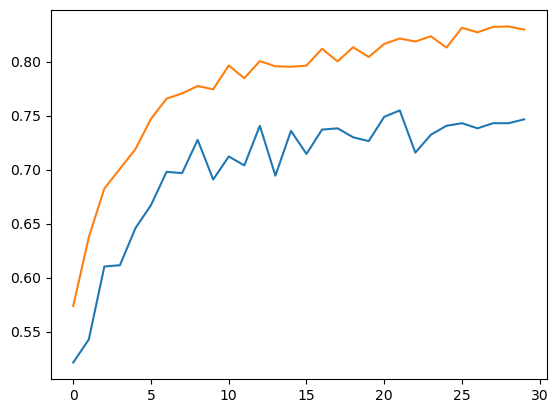

avg_loss 0.7794409138815743
accuracy 0.672686230248307
Shape of X after subsampling and concatenating: (7616, 22, 350)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 350)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 350])
torch.Size([1, 18, 350])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.17it/s, loss=1.02]


Validation set: Average loss = 1.1131, Accuracy = 0.5427
Training set: Average loss = 1.0156, Accuracy = 0.5844


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.11it/s, loss=0.854]


Validation set: Average loss = 0.9969, Accuracy = 0.5841
Training set: Average loss = 0.8993, Accuracy = 0.6435


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.52it/s, loss=1.09]


Validation set: Average loss = 0.9869, Accuracy = 0.5806
Training set: Average loss = 0.8291, Accuracy = 0.6825


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.76it/s, loss=0.952]


Validation set: Average loss = 0.9218, Accuracy = 0.6090
Training set: Average loss = 0.7721, Accuracy = 0.7052


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.36it/s, loss=0.908]


Validation set: Average loss = 0.8704, Accuracy = 0.6623
Training set: Average loss = 0.7218, Accuracy = 0.7277


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.75it/s, loss=0.847]


Validation set: Average loss = 0.8525, Accuracy = 0.6493
Training set: Average loss = 0.6999, Accuracy = 0.7407


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.73it/s, loss=0.799]


Validation set: Average loss = 0.7438, Accuracy = 0.7073
Training set: Average loss = 0.6560, Accuracy = 0.7619


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.27it/s, loss=0.814]


Validation set: Average loss = 0.7527, Accuracy = 0.7121
Training set: Average loss = 0.6312, Accuracy = 0.7683


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.25it/s, loss=0.924]


Validation set: Average loss = 0.7269, Accuracy = 0.7287
Training set: Average loss = 0.6109, Accuracy = 0.7883


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.57it/s, loss=0.763]


Validation set: Average loss = 0.6980, Accuracy = 0.7405
Training set: Average loss = 0.6013, Accuracy = 0.7882


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 16.54it/s, loss=0.91]


Validation set: Average loss = 0.7078, Accuracy = 0.7299
Training set: Average loss = 0.5822, Accuracy = 0.7921


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.29it/s, loss=0.599]


Validation set: Average loss = 0.6947, Accuracy = 0.7168
Training set: Average loss = 0.5712, Accuracy = 0.7998


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.15it/s, loss=0.804]


Validation set: Average loss = 0.6943, Accuracy = 0.7275
Training set: Average loss = 0.5782, Accuracy = 0.7974


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.09it/s, loss=0.625]


Validation set: Average loss = 0.6717, Accuracy = 0.7310
Training set: Average loss = 0.5574, Accuracy = 0.8071


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.19it/s, loss=0.617]


Validation set: Average loss = 0.6881, Accuracy = 0.7310
Training set: Average loss = 0.5653, Accuracy = 0.7952


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.43it/s, loss=0.808]


Validation set: Average loss = 0.6587, Accuracy = 0.7275
Training set: Average loss = 0.5457, Accuracy = 0.8074


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.27it/s, loss=0.64]


Validation set: Average loss = 0.6663, Accuracy = 0.7275
Training set: Average loss = 0.5380, Accuracy = 0.8063


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.62it/s, loss=0.72]


Validation set: Average loss = 0.6814, Accuracy = 0.7512
Training set: Average loss = 0.5441, Accuracy = 0.8050


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.31it/s, loss=0.681]


Validation set: Average loss = 0.6597, Accuracy = 0.7405
Training set: Average loss = 0.5239, Accuracy = 0.8175


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.745]


Validation set: Average loss = 0.6527, Accuracy = 0.7429
Training set: Average loss = 0.5256, Accuracy = 0.8139


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.78it/s, loss=0.738]


Validation set: Average loss = 0.6698, Accuracy = 0.7476
Training set: Average loss = 0.5245, Accuracy = 0.8181


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.85it/s, loss=0.873]


Validation set: Average loss = 0.6301, Accuracy = 0.7559
Training set: Average loss = 0.5106, Accuracy = 0.8237


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.30it/s, loss=0.837]


Validation set: Average loss = 0.6492, Accuracy = 0.7334
Training set: Average loss = 0.5137, Accuracy = 0.8193


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.33it/s, loss=0.517]


Validation set: Average loss = 0.6523, Accuracy = 0.7275
Training set: Average loss = 0.4994, Accuracy = 0.8251


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.32it/s, loss=0.726]


Validation set: Average loss = 0.6387, Accuracy = 0.7476
Training set: Average loss = 0.4981, Accuracy = 0.8256


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.68it/s, loss=0.737]


Validation set: Average loss = 0.6547, Accuracy = 0.7370
Training set: Average loss = 0.5090, Accuracy = 0.8233


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.00it/s, loss=0.665]


Validation set: Average loss = 0.6691, Accuracy = 0.7275
Training set: Average loss = 0.5176, Accuracy = 0.8230


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.00it/s, loss=0.882]


Validation set: Average loss = 0.6379, Accuracy = 0.7464
Training set: Average loss = 0.4902, Accuracy = 0.8262


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.32it/s, loss=0.675]


Validation set: Average loss = 0.6411, Accuracy = 0.7405
Training set: Average loss = 0.4861, Accuracy = 0.8308


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.05it/s, loss=0.657]


Validation set: Average loss = 0.6275, Accuracy = 0.7524
Training set: Average loss = 0.4783, Accuracy = 0.8351


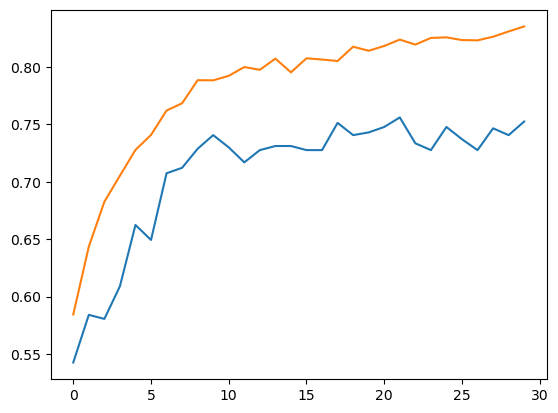

avg_loss 0.7749880467142377
accuracy 0.6817155756207675
Shape of X after subsampling and concatenating: (7616, 22, 375)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 375)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 375])
torch.Size([1, 18, 375])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.58it/s, loss=1.02]


Validation set: Average loss = 1.1182, Accuracy = 0.5107
Training set: Average loss = 1.0104, Accuracy = 0.5932


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.12it/s, loss=0.736]


Validation set: Average loss = 1.0034, Accuracy = 0.6019
Training set: Average loss = 0.9089, Accuracy = 0.6369


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.89it/s, loss=1.12]


Validation set: Average loss = 0.9844, Accuracy = 0.5592
Training set: Average loss = 0.8314, Accuracy = 0.6837


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.33it/s, loss=0.831]


Validation set: Average loss = 0.9480, Accuracy = 0.6149
Training set: Average loss = 0.7934, Accuracy = 0.6921


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.48it/s, loss=0.878]


Validation set: Average loss = 0.9230, Accuracy = 0.6315
Training set: Average loss = 0.7478, Accuracy = 0.7194


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.57it/s, loss=0.779]


Validation set: Average loss = 0.8600, Accuracy = 0.6564
Training set: Average loss = 0.7040, Accuracy = 0.7405


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.33it/s, loss=0.809]


Validation set: Average loss = 0.8298, Accuracy = 0.6777
Training set: Average loss = 0.6788, Accuracy = 0.7504


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.39it/s, loss=0.779]


Validation set: Average loss = 0.8192, Accuracy = 0.6682
Training set: Average loss = 0.6528, Accuracy = 0.7617


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.44it/s, loss=0.842]


Validation set: Average loss = 0.8089, Accuracy = 0.6813
Training set: Average loss = 0.6388, Accuracy = 0.7627


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.81it/s, loss=0.808]


Validation set: Average loss = 0.7883, Accuracy = 0.6765
Training set: Average loss = 0.6173, Accuracy = 0.7784


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.35it/s, loss=1.03]


Validation set: Average loss = 0.7828, Accuracy = 0.6955
Training set: Average loss = 0.6003, Accuracy = 0.7856


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  7.95it/s, loss=0.61]


Validation set: Average loss = 0.7731, Accuracy = 0.7109
Training set: Average loss = 0.5910, Accuracy = 0.7791


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.28it/s, loss=0.814]


Validation set: Average loss = 0.7379, Accuracy = 0.7227
Training set: Average loss = 0.5868, Accuracy = 0.7906


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.20it/s, loss=0.627]


Validation set: Average loss = 0.7594, Accuracy = 0.7109
Training set: Average loss = 0.5758, Accuracy = 0.7949


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.75it/s, loss=0.619]


Validation set: Average loss = 0.7302, Accuracy = 0.7145
Training set: Average loss = 0.5651, Accuracy = 0.8016


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.23it/s, loss=0.697]


Validation set: Average loss = 0.7248, Accuracy = 0.7204
Training set: Average loss = 0.5620, Accuracy = 0.8011


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.19it/s, loss=0.651]


Validation set: Average loss = 0.6943, Accuracy = 0.7251
Training set: Average loss = 0.5427, Accuracy = 0.8113


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.86it/s, loss=0.758]


Validation set: Average loss = 0.7148, Accuracy = 0.7239
Training set: Average loss = 0.5473, Accuracy = 0.8149


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.89it/s, loss=0.771]


Validation set: Average loss = 0.6772, Accuracy = 0.7464
Training set: Average loss = 0.5203, Accuracy = 0.8255


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.57it/s, loss=0.848]


Validation set: Average loss = 0.6988, Accuracy = 0.7393
Training set: Average loss = 0.5303, Accuracy = 0.8122


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.46it/s, loss=0.663]


Validation set: Average loss = 0.6912, Accuracy = 0.7180
Training set: Average loss = 0.5196, Accuracy = 0.8234


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.61it/s, loss=0.757]


Validation set: Average loss = 0.6655, Accuracy = 0.7310
Training set: Average loss = 0.5038, Accuracy = 0.8243


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.38it/s, loss=0.825]


Validation set: Average loss = 0.6680, Accuracy = 0.7299
Training set: Average loss = 0.5020, Accuracy = 0.8297


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.55it/s, loss=0.509]


Validation set: Average loss = 0.7025, Accuracy = 0.6967
Training set: Average loss = 0.5073, Accuracy = 0.8187


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.42it/s, loss=0.596]


Validation set: Average loss = 0.6567, Accuracy = 0.7251
Training set: Average loss = 0.4961, Accuracy = 0.8214


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.18it/s, loss=0.759]


Validation set: Average loss = 0.6634, Accuracy = 0.7334
Training set: Average loss = 0.4919, Accuracy = 0.8330


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.82it/s, loss=0.643]


Validation set: Average loss = 0.6477, Accuracy = 0.7536
Training set: Average loss = 0.4916, Accuracy = 0.8377


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.05it/s, loss=0.925]


Validation set: Average loss = 0.6355, Accuracy = 0.7500
Training set: Average loss = 0.4766, Accuracy = 0.8435


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 14.13it/s, loss=0.551]


Validation set: Average loss = 0.6448, Accuracy = 0.7607
Training set: Average loss = 0.4767, Accuracy = 0.8384


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.26it/s, loss=0.838]


Validation set: Average loss = 0.6554, Accuracy = 0.7216
Training set: Average loss = 0.4741, Accuracy = 0.8374


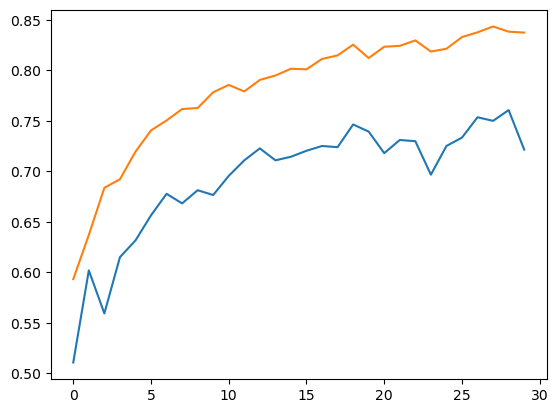

avg_loss 0.8040861317089626
accuracy 0.6681715575620768
Shape of X after subsampling and concatenating: (7616, 22, 400)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 400)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 400])
torch.Size([1, 18, 400])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.36it/s, loss=1.01]


Validation set: Average loss = 1.1135, Accuracy = 0.5403
Training set: Average loss = 1.0057, Accuracy = 0.5953


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.68it/s, loss=0.91]


Validation set: Average loss = 1.0170, Accuracy = 0.5403
Training set: Average loss = 0.8807, Accuracy = 0.6539


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.11it/s, loss=0.975]


Validation set: Average loss = 0.9755, Accuracy = 0.5841
Training set: Average loss = 0.8264, Accuracy = 0.6832


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00,  9.93it/s, loss=0.949]


Validation set: Average loss = 0.9563, Accuracy = 0.5889
Training set: Average loss = 0.7861, Accuracy = 0.7082


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.00it/s, loss=0.776]


Validation set: Average loss = 0.9461, Accuracy = 0.5794
Training set: Average loss = 0.7473, Accuracy = 0.7264


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.58it/s, loss=0.922]


Validation set: Average loss = 0.9151, Accuracy = 0.5972
Training set: Average loss = 0.7129, Accuracy = 0.7507


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.40it/s, loss=0.691]


Validation set: Average loss = 0.9263, Accuracy = 0.5877
Training set: Average loss = 0.6970, Accuracy = 0.7537


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.68it/s, loss=0.843]


Validation set: Average loss = 0.8577, Accuracy = 0.6173
Training set: Average loss = 0.6817, Accuracy = 0.7622


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.52it/s, loss=0.977]


Validation set: Average loss = 0.8654, Accuracy = 0.6149
Training set: Average loss = 0.6579, Accuracy = 0.7688


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.92it/s, loss=0.87]


Validation set: Average loss = 0.8697, Accuracy = 0.6445
Training set: Average loss = 0.6399, Accuracy = 0.7714


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.50it/s, loss=0.759]


Validation set: Average loss = 0.8359, Accuracy = 0.6588
Training set: Average loss = 0.6273, Accuracy = 0.7774


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.37it/s, loss=0.937]


Validation set: Average loss = 0.8066, Accuracy = 0.6706
Training set: Average loss = 0.6021, Accuracy = 0.7933


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.20it/s, loss=0.756]


Validation set: Average loss = 0.8199, Accuracy = 0.6694
Training set: Average loss = 0.6108, Accuracy = 0.7876


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.41it/s, loss=0.676]


Validation set: Average loss = 0.8038, Accuracy = 0.6623
Training set: Average loss = 0.6112, Accuracy = 0.7841


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.72it/s, loss=0.695]


Validation set: Average loss = 0.7691, Accuracy = 0.6718
Training set: Average loss = 0.5801, Accuracy = 0.8032


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.60it/s, loss=0.575]


Validation set: Average loss = 0.7797, Accuracy = 0.6706
Training set: Average loss = 0.5660, Accuracy = 0.8017


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.73it/s, loss=0.621]


Validation set: Average loss = 0.7500, Accuracy = 0.7180
Training set: Average loss = 0.5594, Accuracy = 0.8113


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.57it/s, loss=0.661]


Validation set: Average loss = 0.7499, Accuracy = 0.7073
Training set: Average loss = 0.5562, Accuracy = 0.8021


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.35it/s, loss=0.832]


Validation set: Average loss = 0.7415, Accuracy = 0.6884
Training set: Average loss = 0.5428, Accuracy = 0.8112


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.96it/s, loss=0.695]


Validation set: Average loss = 0.7479, Accuracy = 0.6955
Training set: Average loss = 0.5378, Accuracy = 0.8170


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.02it/s, loss=0.75]


Validation set: Average loss = 0.7528, Accuracy = 0.6991
Training set: Average loss = 0.5268, Accuracy = 0.8234


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.67it/s, loss=0.939]


Validation set: Average loss = 0.7387, Accuracy = 0.7026
Training set: Average loss = 0.5207, Accuracy = 0.8221


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.81it/s, loss=0.694]


Validation set: Average loss = 0.6872, Accuracy = 0.7263
Training set: Average loss = 0.4979, Accuracy = 0.8339


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.99it/s, loss=0.781]


Validation set: Average loss = 0.7242, Accuracy = 0.7121
Training set: Average loss = 0.4996, Accuracy = 0.8285


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.04it/s, loss=0.674]


Validation set: Average loss = 0.7099, Accuracy = 0.7192
Training set: Average loss = 0.5140, Accuracy = 0.8208


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.89it/s, loss=0.66]


Validation set: Average loss = 0.7201, Accuracy = 0.7073
Training set: Average loss = 0.5080, Accuracy = 0.8269


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.22it/s, loss=0.599]


Validation set: Average loss = 0.7065, Accuracy = 0.7251
Training set: Average loss = 0.4868, Accuracy = 0.8397


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.11it/s, loss=0.698]


Validation set: Average loss = 0.6915, Accuracy = 0.7299
Training set: Average loss = 0.4893, Accuracy = 0.8360


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.35it/s, loss=0.699]


Validation set: Average loss = 0.6712, Accuracy = 0.7453
Training set: Average loss = 0.4687, Accuracy = 0.8449


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.73it/s, loss=0.641]


Validation set: Average loss = 0.6902, Accuracy = 0.7382
Training set: Average loss = 0.4809, Accuracy = 0.8399


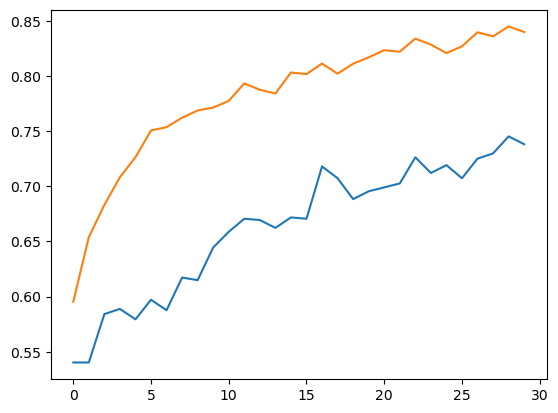

avg_loss 0.8258780837059021
accuracy 0.6523702031602708
Shape of X after subsampling and concatenating: (7616, 22, 425)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 425)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 425])
torch.Size([1, 18, 425])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.33it/s, loss=1.18]


Validation set: Average loss = 1.1687, Accuracy = 0.5059
Training set: Average loss = 1.0202, Accuracy = 0.5867


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.67it/s, loss=0.879]


Validation set: Average loss = 1.0714, Accuracy = 0.5628
Training set: Average loss = 0.8899, Accuracy = 0.6566


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.54it/s, loss=1.02]


Validation set: Average loss = 1.0139, Accuracy = 0.5462
Training set: Average loss = 0.8344, Accuracy = 0.6787


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.50it/s, loss=0.882]


Validation set: Average loss = 0.9822, Accuracy = 0.5960
Training set: Average loss = 0.7961, Accuracy = 0.6925


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 13.06it/s, loss=0.745]


Validation set: Average loss = 0.9333, Accuracy = 0.6161
Training set: Average loss = 0.7538, Accuracy = 0.7223


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.89it/s, loss=1.05]


Validation set: Average loss = 0.9202, Accuracy = 0.6114
Training set: Average loss = 0.7249, Accuracy = 0.7298


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.14it/s, loss=0.924]


Validation set: Average loss = 0.8985, Accuracy = 0.6102
Training set: Average loss = 0.6761, Accuracy = 0.7562


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.12it/s, loss=0.92]


Validation set: Average loss = 0.8364, Accuracy = 0.6718
Training set: Average loss = 0.6433, Accuracy = 0.7739


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.74it/s, loss=0.751]


Validation set: Average loss = 0.8408, Accuracy = 0.6552
Training set: Average loss = 0.6302, Accuracy = 0.7753


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.73it/s, loss=0.77]


Validation set: Average loss = 0.7818, Accuracy = 0.6896
Training set: Average loss = 0.5891, Accuracy = 0.7969


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  5.97it/s, loss=0.797]


Validation set: Average loss = 0.7663, Accuracy = 0.6813
Training set: Average loss = 0.5759, Accuracy = 0.7987


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.83it/s, loss=0.548]


Validation set: Average loss = 0.7460, Accuracy = 0.6777
Training set: Average loss = 0.5652, Accuracy = 0.8042


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.31it/s, loss=0.731]


Validation set: Average loss = 0.7509, Accuracy = 0.6789
Training set: Average loss = 0.5577, Accuracy = 0.8025


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.69it/s, loss=0.865]


Validation set: Average loss = 0.7140, Accuracy = 0.7133
Training set: Average loss = 0.5307, Accuracy = 0.8113


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.55it/s, loss=0.666]


Validation set: Average loss = 0.7374, Accuracy = 0.6908
Training set: Average loss = 0.5431, Accuracy = 0.8061


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.83it/s, loss=0.725]


Validation set: Average loss = 0.6660, Accuracy = 0.7097
Training set: Average loss = 0.5061, Accuracy = 0.8353


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.72it/s, loss=0.781]


Validation set: Average loss = 0.7109, Accuracy = 0.7062
Training set: Average loss = 0.5101, Accuracy = 0.8280


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.40it/s, loss=0.782]


Validation set: Average loss = 0.7109, Accuracy = 0.6647
Training set: Average loss = 0.5197, Accuracy = 0.8216


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.06it/s, loss=0.862]


Validation set: Average loss = 0.6855, Accuracy = 0.7180
Training set: Average loss = 0.5030, Accuracy = 0.8251


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:22<00:00,  5.38it/s, loss=0.579]


Validation set: Average loss = 0.6628, Accuracy = 0.7180
Training set: Average loss = 0.4798, Accuracy = 0.8424


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.85it/s, loss=0.698]


Validation set: Average loss = 0.6814, Accuracy = 0.7287
Training set: Average loss = 0.4975, Accuracy = 0.8281


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.81it/s, loss=0.79]


Validation set: Average loss = 0.6398, Accuracy = 0.7358
Training set: Average loss = 0.4647, Accuracy = 0.8456


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.48it/s, loss=0.679]


Validation set: Average loss = 0.6447, Accuracy = 0.7204
Training set: Average loss = 0.4685, Accuracy = 0.8416


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.05it/s, loss=0.496]


Validation set: Average loss = 0.6350, Accuracy = 0.7263
Training set: Average loss = 0.4619, Accuracy = 0.8482


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.30it/s, loss=0.847]


Validation set: Average loss = 0.6574, Accuracy = 0.7109
Training set: Average loss = 0.4680, Accuracy = 0.8431


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.00it/s, loss=0.586]


Validation set: Average loss = 0.6212, Accuracy = 0.7429
Training set: Average loss = 0.4552, Accuracy = 0.8522


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.04it/s, loss=0.749]


Validation set: Average loss = 0.6807, Accuracy = 0.7287
Training set: Average loss = 0.4792, Accuracy = 0.8347


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.25it/s, loss=0.568]


Validation set: Average loss = 0.6345, Accuracy = 0.7405
Training set: Average loss = 0.4557, Accuracy = 0.8531


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.71it/s, loss=0.738]


Validation set: Average loss = 0.6311, Accuracy = 0.7429
Training set: Average loss = 0.4347, Accuracy = 0.8603


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.62it/s, loss=0.688]


Validation set: Average loss = 0.6197, Accuracy = 0.7358
Training set: Average loss = 0.4398, Accuracy = 0.8562


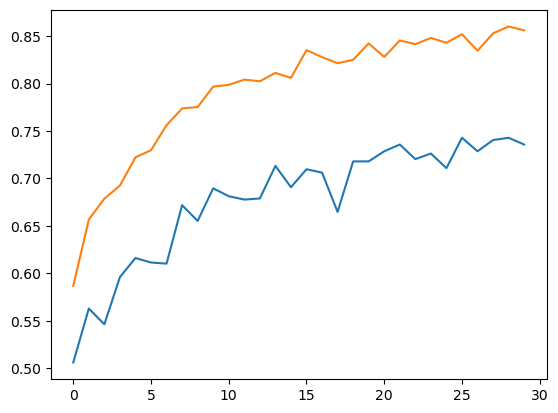

avg_loss 0.7732135398047311
accuracy 0.6772009029345373
Shape of X after subsampling and concatenating: (7616, 22, 450)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 450)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 450])
torch.Size([1, 18, 450])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.36it/s, loss=1.13]


Validation set: Average loss = 1.1472, Accuracy = 0.5036
Training set: Average loss = 1.0125, Accuracy = 0.5895


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.33it/s, loss=0.983]


Validation set: Average loss = 1.0464, Accuracy = 0.5604
Training set: Average loss = 0.8835, Accuracy = 0.6535


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.57it/s, loss=1]


Validation set: Average loss = 0.9983, Accuracy = 0.5818
Training set: Average loss = 0.8055, Accuracy = 0.6985


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.12it/s, loss=0.977]


Validation set: Average loss = 0.9700, Accuracy = 0.6055
Training set: Average loss = 0.7525, Accuracy = 0.7283


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.77it/s, loss=0.847]


Validation set: Average loss = 0.9033, Accuracy = 0.6280
Training set: Average loss = 0.7141, Accuracy = 0.7396


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.61it/s, loss=0.689]


Validation set: Average loss = 0.8646, Accuracy = 0.6469
Training set: Average loss = 0.6655, Accuracy = 0.7602


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.05it/s, loss=0.841]


Validation set: Average loss = 0.8289, Accuracy = 0.6671
Training set: Average loss = 0.6275, Accuracy = 0.7780


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:20<00:00,  5.77it/s, loss=0.856]


Validation set: Average loss = 0.8053, Accuracy = 0.6884
Training set: Average loss = 0.6119, Accuracy = 0.7848


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.12it/s, loss=0.64]


Validation set: Average loss = 0.7733, Accuracy = 0.7133
Training set: Average loss = 0.5812, Accuracy = 0.8008


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.82it/s, loss=0.693]


Validation set: Average loss = 0.8015, Accuracy = 0.6979
Training set: Average loss = 0.5809, Accuracy = 0.7902


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:08<00:00, 13.31it/s, loss=0.734]


Validation set: Average loss = 0.7509, Accuracy = 0.7192
Training set: Average loss = 0.5551, Accuracy = 0.8090


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.50it/s, loss=0.657]


Validation set: Average loss = 0.7808, Accuracy = 0.6872
Training set: Average loss = 0.5533, Accuracy = 0.8048


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.72it/s, loss=0.761]


Validation set: Average loss = 0.7441, Accuracy = 0.7002
Training set: Average loss = 0.5414, Accuracy = 0.8082


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.31it/s, loss=0.784]


Validation set: Average loss = 0.7242, Accuracy = 0.7239
Training set: Average loss = 0.5241, Accuracy = 0.8234


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.74it/s, loss=0.747]


Validation set: Average loss = 0.7299, Accuracy = 0.7275
Training set: Average loss = 0.5166, Accuracy = 0.8234


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.77it/s, loss=0.456]


Validation set: Average loss = 0.7128, Accuracy = 0.7180
Training set: Average loss = 0.5157, Accuracy = 0.8272


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.28it/s, loss=0.523]


Validation set: Average loss = 0.7095, Accuracy = 0.7346
Training set: Average loss = 0.5108, Accuracy = 0.8229


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.78it/s, loss=0.877]


Validation set: Average loss = 0.7214, Accuracy = 0.7062
Training set: Average loss = 0.4961, Accuracy = 0.8306


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:21<00:00,  5.58it/s, loss=0.676]


Validation set: Average loss = 0.7088, Accuracy = 0.7334
Training set: Average loss = 0.4972, Accuracy = 0.8298


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:24<00:00,  4.76it/s, loss=0.752]


Validation set: Average loss = 0.7050, Accuracy = 0.7204
Training set: Average loss = 0.4897, Accuracy = 0.8364


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.59it/s, loss=0.869]


Validation set: Average loss = 0.6969, Accuracy = 0.7299
Training set: Average loss = 0.4888, Accuracy = 0.8318


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.854]


Validation set: Average loss = 0.6969, Accuracy = 0.7133
Training set: Average loss = 0.4944, Accuracy = 0.8314


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.11it/s, loss=0.695]


Validation set: Average loss = 0.6996, Accuracy = 0.7204
Training set: Average loss = 0.4921, Accuracy = 0.8268


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.35it/s, loss=0.815]


Validation set: Average loss = 0.6872, Accuracy = 0.7322
Training set: Average loss = 0.4855, Accuracy = 0.8297


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.54it/s, loss=0.652]


Validation set: Average loss = 0.6688, Accuracy = 0.7370
Training set: Average loss = 0.4733, Accuracy = 0.8378


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.41it/s, loss=0.667]


Validation set: Average loss = 0.6864, Accuracy = 0.7239
Training set: Average loss = 0.4698, Accuracy = 0.8382


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.63it/s, loss=0.694]


Validation set: Average loss = 0.6800, Accuracy = 0.7453
Training set: Average loss = 0.4549, Accuracy = 0.8461


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.21it/s, loss=0.665]


Validation set: Average loss = 0.6498, Accuracy = 0.7583
Training set: Average loss = 0.4520, Accuracy = 0.8452


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.03it/s, loss=0.627]


Validation set: Average loss = 0.6554, Accuracy = 0.7547
Training set: Average loss = 0.4476, Accuracy = 0.8515


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.33it/s, loss=0.607]


Validation set: Average loss = 0.6696, Accuracy = 0.7453
Training set: Average loss = 0.4567, Accuracy = 0.8407


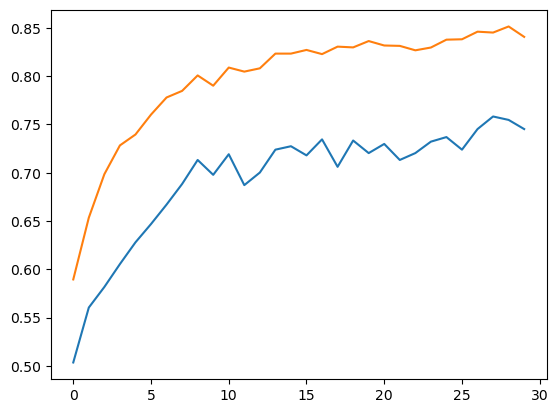

avg_loss 0.8112199987683978
accuracy 0.690744920993228
Shape of X after subsampling and concatenating: (7616, 22, 475)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 475)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 475])
torch.Size([1, 18, 475])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.38it/s, loss=1.14]


Validation set: Average loss = 1.1435, Accuracy = 0.5438
Training set: Average loss = 1.0193, Accuracy = 0.5722


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:09<00:00, 12.23it/s, loss=1.13]


Validation set: Average loss = 1.0268, Accuracy = 0.5782
Training set: Average loss = 0.8721, Accuracy = 0.6622


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.63it/s, loss=1.13]


Validation set: Average loss = 0.9734, Accuracy = 0.6066
Training set: Average loss = 0.7985, Accuracy = 0.6996


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.68it/s, loss=1.03]


Validation set: Average loss = 0.9723, Accuracy = 0.6161
Training set: Average loss = 0.7549, Accuracy = 0.7174


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.42it/s, loss=0.8]


Validation set: Average loss = 0.9362, Accuracy = 0.6173
Training set: Average loss = 0.7213, Accuracy = 0.7354


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.53it/s, loss=0.674]


Validation set: Average loss = 0.9094, Accuracy = 0.6232
Training set: Average loss = 0.6899, Accuracy = 0.7525


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.06it/s, loss=1.02]


Validation set: Average loss = 0.8616, Accuracy = 0.6588
Training set: Average loss = 0.6472, Accuracy = 0.7728


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:20<00:00,  5.80it/s, loss=0.738]


Validation set: Average loss = 0.8285, Accuracy = 0.6896
Training set: Average loss = 0.6072, Accuracy = 0.7865


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:24<00:00,  4.78it/s, loss=0.756]


Validation set: Average loss = 0.8174, Accuracy = 0.7050
Training set: Average loss = 0.5932, Accuracy = 0.7948


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:23<00:00,  4.98it/s, loss=0.933]


Validation set: Average loss = 0.7964, Accuracy = 0.6742
Training set: Average loss = 0.5782, Accuracy = 0.7988


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:22<00:00,  5.38it/s, loss=0.677]


Validation set: Average loss = 0.7886, Accuracy = 0.7085
Training set: Average loss = 0.5701, Accuracy = 0.8024


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.02it/s, loss=0.717]


Validation set: Average loss = 0.7449, Accuracy = 0.7168
Training set: Average loss = 0.5420, Accuracy = 0.8138


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.74it/s, loss=0.608]


Validation set: Average loss = 0.7340, Accuracy = 0.7085
Training set: Average loss = 0.5108, Accuracy = 0.8265


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.56it/s, loss=0.589]


Validation set: Average loss = 0.7375, Accuracy = 0.6955
Training set: Average loss = 0.5227, Accuracy = 0.8179


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.24it/s, loss=0.682]


Validation set: Average loss = 0.7673, Accuracy = 0.6991
Training set: Average loss = 0.5182, Accuracy = 0.8185


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:23<00:00,  5.10it/s, loss=0.446]


Validation set: Average loss = 0.7417, Accuracy = 0.7145
Training set: Average loss = 0.4870, Accuracy = 0.8360


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:22<00:00,  5.35it/s, loss=0.707]


Validation set: Average loss = 0.7147, Accuracy = 0.7097
Training set: Average loss = 0.4847, Accuracy = 0.8350


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.75it/s, loss=0.645]


Validation set: Average loss = 0.7245, Accuracy = 0.7168
Training set: Average loss = 0.4827, Accuracy = 0.8384


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.08it/s, loss=0.486]


Validation set: Average loss = 0.7158, Accuracy = 0.7145
Training set: Average loss = 0.4792, Accuracy = 0.8367


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.82it/s, loss=0.64]


Validation set: Average loss = 0.6966, Accuracy = 0.7133
Training set: Average loss = 0.4622, Accuracy = 0.8486


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.16it/s, loss=0.868]


Validation set: Average loss = 0.6832, Accuracy = 0.7287
Training set: Average loss = 0.4433, Accuracy = 0.8571


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.64it/s, loss=0.766]


Validation set: Average loss = 0.6652, Accuracy = 0.7405
Training set: Average loss = 0.4457, Accuracy = 0.8566


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.99it/s, loss=0.556]


Validation set: Average loss = 0.6577, Accuracy = 0.7453
Training set: Average loss = 0.4286, Accuracy = 0.8617


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.74it/s, loss=0.554]


Validation set: Average loss = 0.6563, Accuracy = 0.7488
Training set: Average loss = 0.4282, Accuracy = 0.8619


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  7.97it/s, loss=0.67]


Validation set: Average loss = 0.6576, Accuracy = 0.7346
Training set: Average loss = 0.4261, Accuracy = 0.8611


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.56it/s, loss=0.612]


Validation set: Average loss = 0.6431, Accuracy = 0.7453
Training set: Average loss = 0.4143, Accuracy = 0.8684


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:27<00:00,  4.27it/s, loss=0.682]


Validation set: Average loss = 0.6661, Accuracy = 0.7322
Training set: Average loss = 0.4223, Accuracy = 0.8577


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:29<00:00,  3.97it/s, loss=0.709]


Validation set: Average loss = 0.6455, Accuracy = 0.7227
Training set: Average loss = 0.4032, Accuracy = 0.8721


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:21<00:00,  5.54it/s, loss=0.495]


Validation set: Average loss = 0.6447, Accuracy = 0.7453
Training set: Average loss = 0.4012, Accuracy = 0.8700


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.80it/s, loss=0.65]


Validation set: Average loss = 0.6343, Accuracy = 0.7571
Training set: Average loss = 0.4009, Accuracy = 0.8720


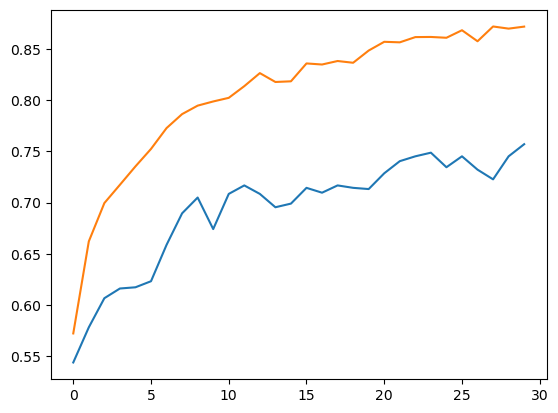

avg_loss 0.7563822269439697
accuracy 0.7178329571106095
Shape of X after subsampling and concatenating: (7616, 22, 500)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 500)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 500])
torch.Size([1, 18, 500])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.87it/s, loss=1.09]


Validation set: Average loss = 1.1246, Accuracy = 0.5569
Training set: Average loss = 0.9998, Accuracy = 0.5859


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.17it/s, loss=1.06]


Validation set: Average loss = 1.0285, Accuracy = 0.5806
Training set: Average loss = 0.8685, Accuracy = 0.6640


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.10it/s, loss=1.02]


Validation set: Average loss = 0.9685, Accuracy = 0.6114
Training set: Average loss = 0.8057, Accuracy = 0.7050


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.79it/s, loss=1.04]


Validation set: Average loss = 0.9648, Accuracy = 0.6161
Training set: Average loss = 0.7564, Accuracy = 0.7170


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.14it/s, loss=0.823]


Validation set: Average loss = 0.9358, Accuracy = 0.6209
Training set: Average loss = 0.7227, Accuracy = 0.7342


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.65it/s, loss=0.66]


Validation set: Average loss = 0.8890, Accuracy = 0.6481
Training set: Average loss = 0.6894, Accuracy = 0.7509


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:26<00:00,  4.52it/s, loss=0.964]


Validation set: Average loss = 0.8354, Accuracy = 0.6730
Training set: Average loss = 0.6646, Accuracy = 0.7587


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:20<00:00,  5.88it/s, loss=0.712]


Validation set: Average loss = 0.8364, Accuracy = 0.6671
Training set: Average loss = 0.6212, Accuracy = 0.7840


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  7.99it/s, loss=0.732]


Validation set: Average loss = 0.8119, Accuracy = 0.6943
Training set: Average loss = 0.6089, Accuracy = 0.7845


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.91it/s, loss=0.957]


Validation set: Average loss = 0.7824, Accuracy = 0.6908
Training set: Average loss = 0.5851, Accuracy = 0.7996


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  9.06it/s, loss=0.764]


Validation set: Average loss = 0.7634, Accuracy = 0.7038
Training set: Average loss = 0.5707, Accuracy = 0.7979


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.77it/s, loss=0.671]


Validation set: Average loss = 0.7435, Accuracy = 0.7145
Training set: Average loss = 0.5490, Accuracy = 0.8147


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.05it/s, loss=0.582]


Validation set: Average loss = 0.7225, Accuracy = 0.7073
Training set: Average loss = 0.5317, Accuracy = 0.8201


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.05it/s, loss=0.614]


Validation set: Average loss = 0.7592, Accuracy = 0.6919
Training set: Average loss = 0.5571, Accuracy = 0.8017


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:28<00:00,  4.21it/s, loss=0.76]


Validation set: Average loss = 0.7373, Accuracy = 0.7050
Training set: Average loss = 0.5270, Accuracy = 0.8201


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:23<00:00,  5.07it/s, loss=0.551]


Validation set: Average loss = 0.7146, Accuracy = 0.7180
Training set: Average loss = 0.4979, Accuracy = 0.8298


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:21<00:00,  5.63it/s, loss=0.68]


Validation set: Average loss = 0.7197, Accuracy = 0.7204
Training set: Average loss = 0.4936, Accuracy = 0.8346


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.89it/s, loss=0.758]


Validation set: Average loss = 0.7468, Accuracy = 0.7073
Training set: Average loss = 0.5101, Accuracy = 0.8191


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.64it/s, loss=0.505]


Validation set: Average loss = 0.7218, Accuracy = 0.7168
Training set: Average loss = 0.4849, Accuracy = 0.8419


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.57it/s, loss=0.591]


Validation set: Average loss = 0.7281, Accuracy = 0.7002
Training set: Average loss = 0.4767, Accuracy = 0.8419


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.40it/s, loss=0.711]


Validation set: Average loss = 0.7128, Accuracy = 0.7026
Training set: Average loss = 0.4598, Accuracy = 0.8512


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.87it/s, loss=0.586]


Validation set: Average loss = 0.7011, Accuracy = 0.7334
Training set: Average loss = 0.4611, Accuracy = 0.8543


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  8.49it/s, loss=0.594]


Validation set: Average loss = 0.7187, Accuracy = 0.7109
Training set: Average loss = 0.4606, Accuracy = 0.8464


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:20<00:00,  5.73it/s, loss=0.546]


Validation set: Average loss = 0.6914, Accuracy = 0.7310
Training set: Average loss = 0.4565, Accuracy = 0.8487


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:23<00:00,  5.03it/s, loss=0.644]


Validation set: Average loss = 0.7227, Accuracy = 0.7097
Training set: Average loss = 0.4535, Accuracy = 0.8480


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:23<00:00,  5.14it/s, loss=0.742]


Validation set: Average loss = 0.7149, Accuracy = 0.7168
Training set: Average loss = 0.4433, Accuracy = 0.8518


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:21<00:00,  5.49it/s, loss=0.56]


Validation set: Average loss = 0.7029, Accuracy = 0.7263
Training set: Average loss = 0.4494, Accuracy = 0.8489


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:18<00:00,  6.30it/s, loss=0.734]


Validation set: Average loss = 0.6895, Accuracy = 0.7251
Training set: Average loss = 0.4311, Accuracy = 0.8612


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.44it/s, loss=0.612]


Validation set: Average loss = 0.6858, Accuracy = 0.7464
Training set: Average loss = 0.4294, Accuracy = 0.8617


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:11<00:00, 10.16it/s, loss=0.691]


Validation set: Average loss = 0.6702, Accuracy = 0.7441
Training set: Average loss = 0.4223, Accuracy = 0.8652


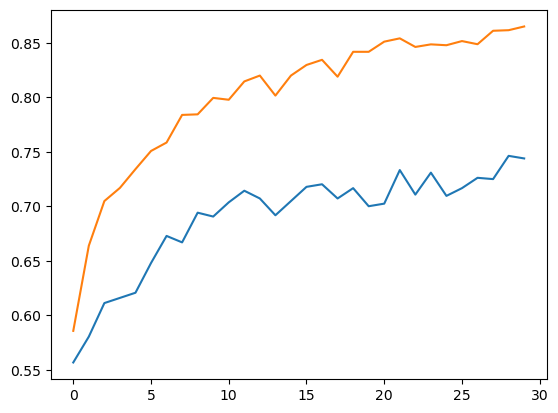

avg_loss 0.7403473172869001
accuracy 0.708803611738149


In [17]:
import json
for cutoff in range(100, 1050, 50):

      # @title Data loading
      data_root = "../project_data/project/"
      if GOOGLE:
            data_root = "/contentimestopt/drive/MyDrive/project/"
      data_transform =  lambda x: (x.reshape(1, x.shape[0],x.shape[1]))
      preprocess = lambda x,y:train_data_prep(x,y,2,2,True, cutoff)
      # Create eeg dataset object
      eeg_train = EEG_Data(data_root,
                                    split='train',
                                    preprocess=preprocess,
                                    transform=data_transform)

      eeg_val = EEG_Data(data_root,
                              split='val',
                              preprocess=preprocess,
                              transform=data_transform)
      eeg_test = EEG_Data(data_root,
                              split='test',
                              preprocess=lambda x:test_data_prep(x, 2, cutoff),
                              transform=data_transform)
      print("val split: ", len(eeg_val))
      print("train split: ", len(eeg_train))
      print(eeg_train[0][0].shape)
      print(eeg_train[0][0][:,0:18,:].shape)
      # Create the dataloaders
      # Define the batch size and number of workers
      batch_size = 64
      num_workers=2
      # Create DataLoader for trainimport torch
      train_loader = DataLoader(eeg_train,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
      val_loader = DataLoader(eeg_val,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)
      test_loader = DataLoader(eeg_test,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)

      seed_everything(0)

      model = EEGNet(cutoff=cutoff)

      model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

      # Let's test_loaderss function, your implementation and the built-in loss function should
      # be almost identical.
      criterion = nn.CrossEntropyLoss()
      # Train the model
      loss_history_train, loss_history_val = train(model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            device,
            num_epochs=30)
      all_result[cutoff] = {"train_acc_history": loss_history_train, "val_acc_history":loss_history_val}
      avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

      torch.save(model.state_dict(), "./"+str(cutoff)+".zip")
      json.dump(all_result, open("./results.json", "w"))
      print("avg_loss", avg_loss)
      print("accuracy", accuracy)



## Visualization of Results

### Load result

If you already have the results saved in Json, you can load with code

In [2]:
import json
SAVED = True

all_result = {}

if SAVED:
    temp_result = json.load(open("./results.json","r"))
    for i in temp_result.keys():
        all_result[int(i)] = temp_result[i]

### Training loss and validation loss graph for each cutoff

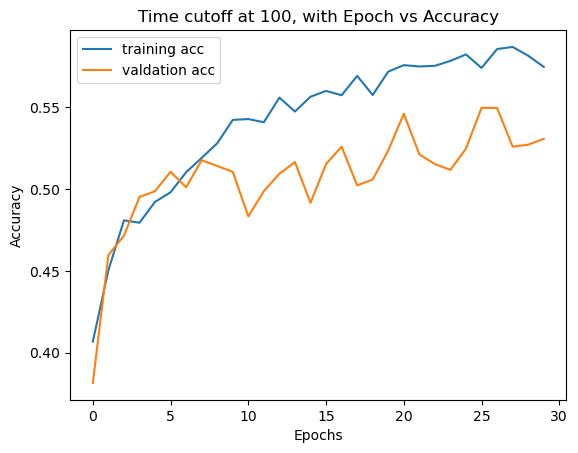

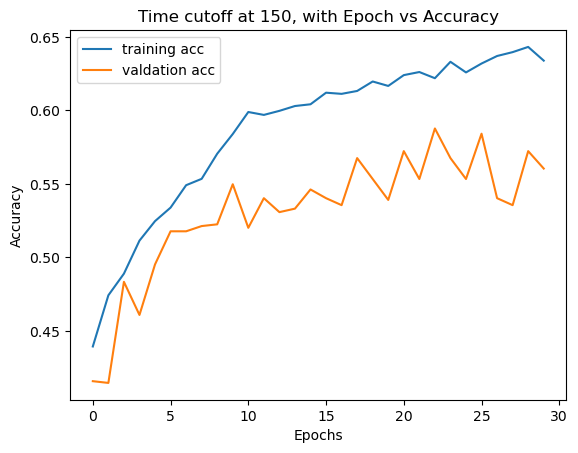

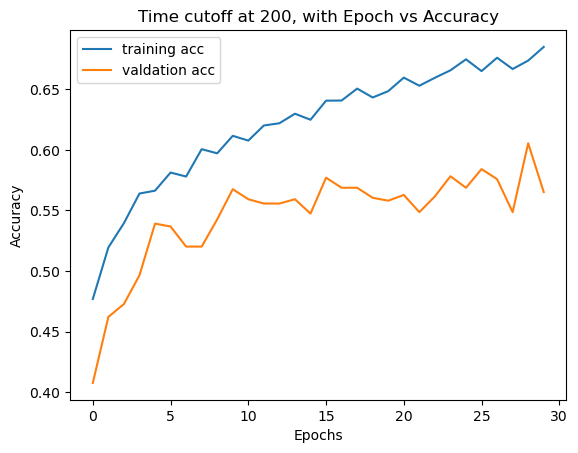

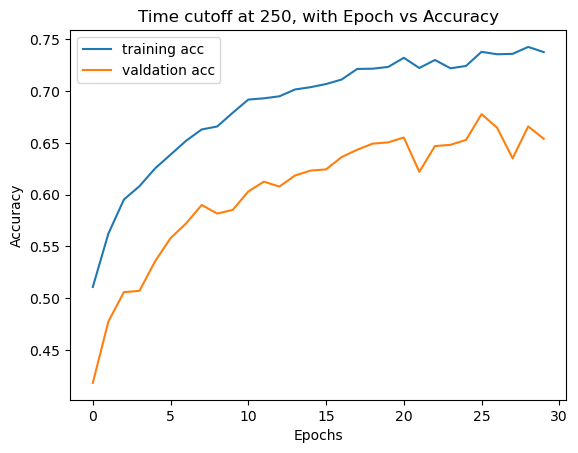

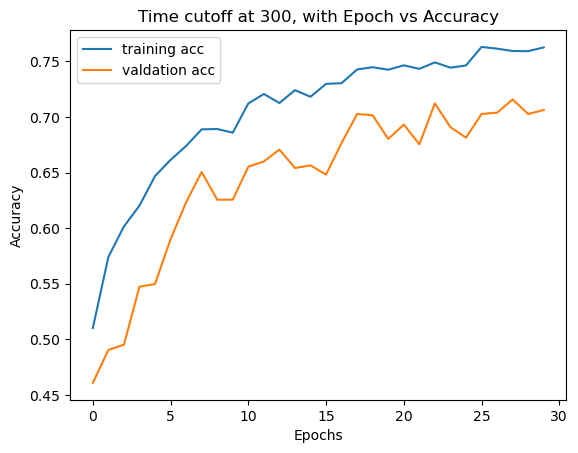

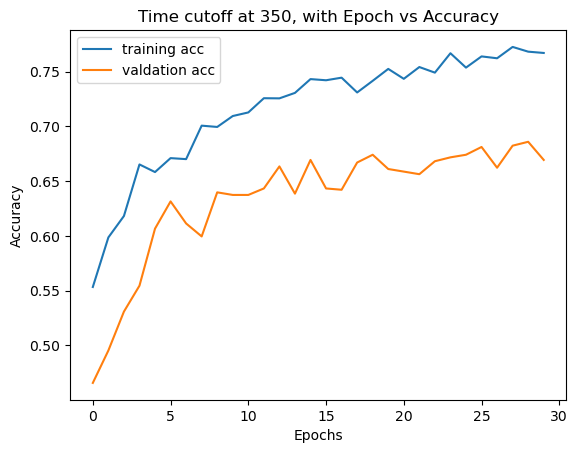

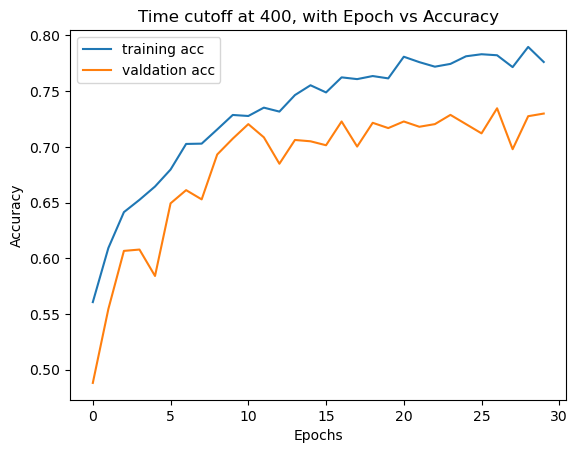

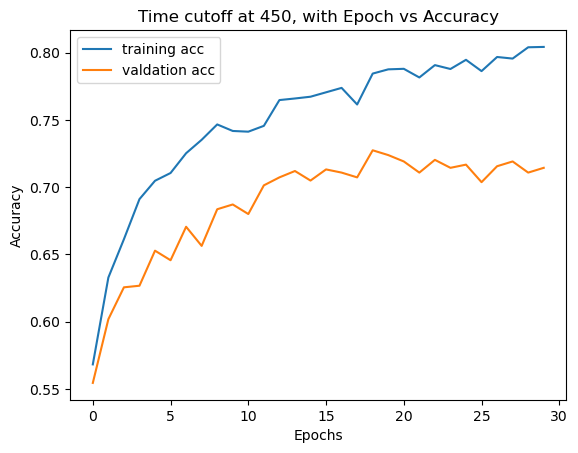

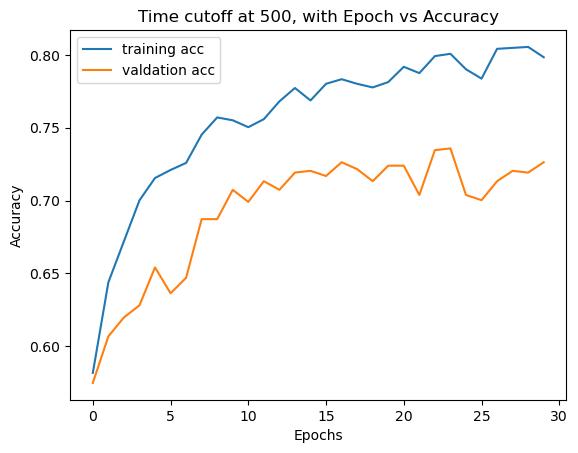

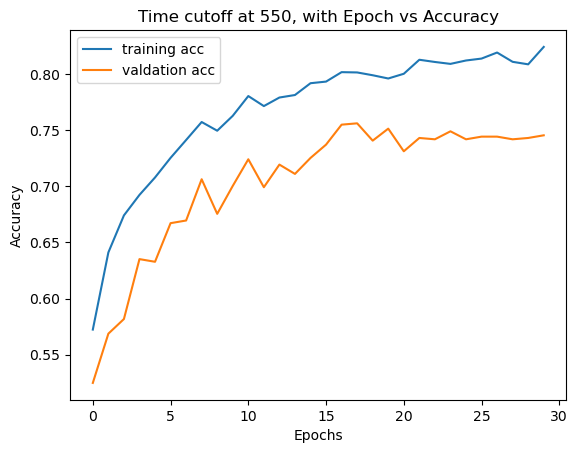

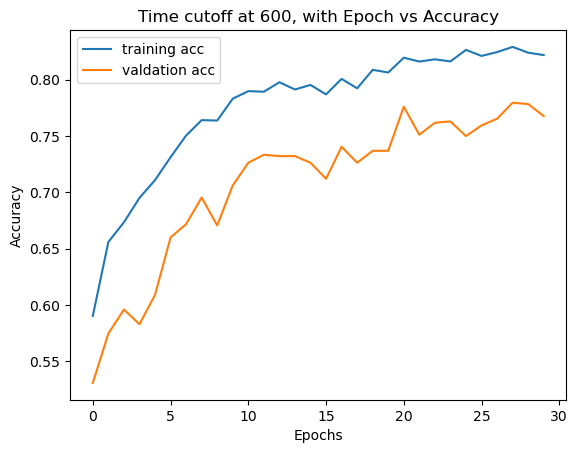

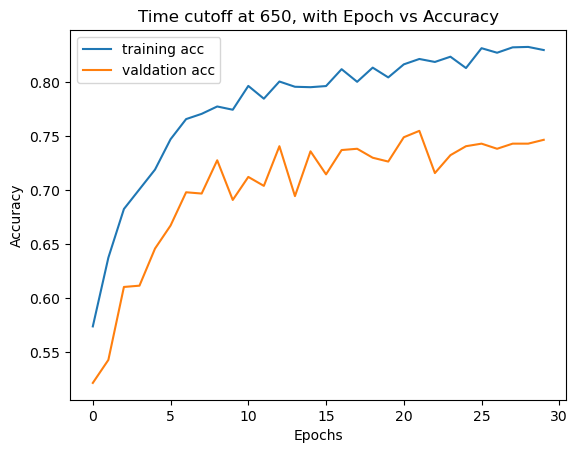

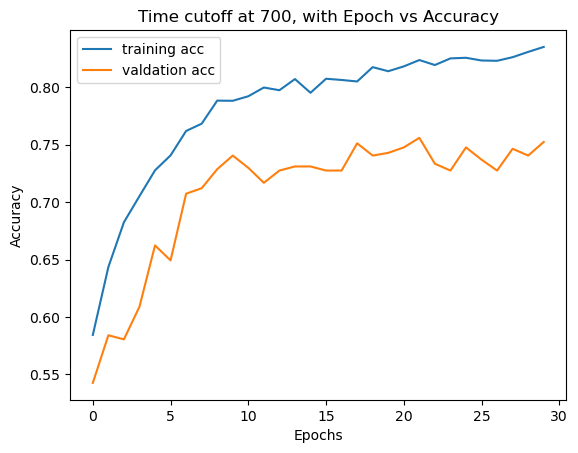

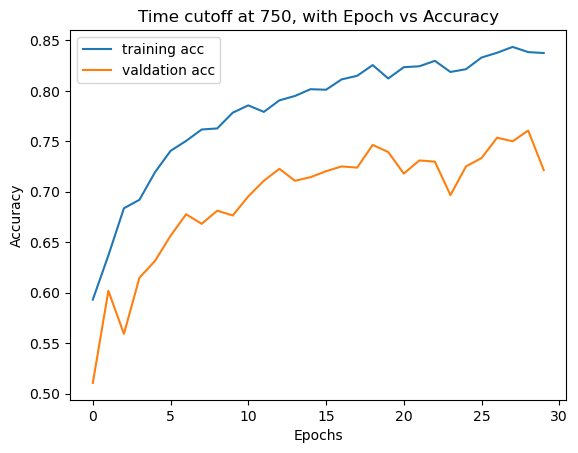

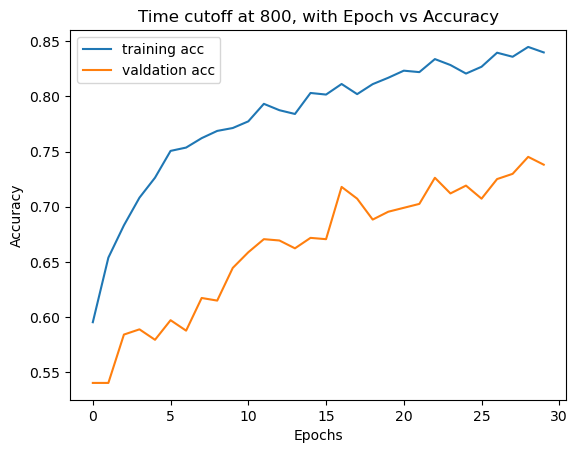

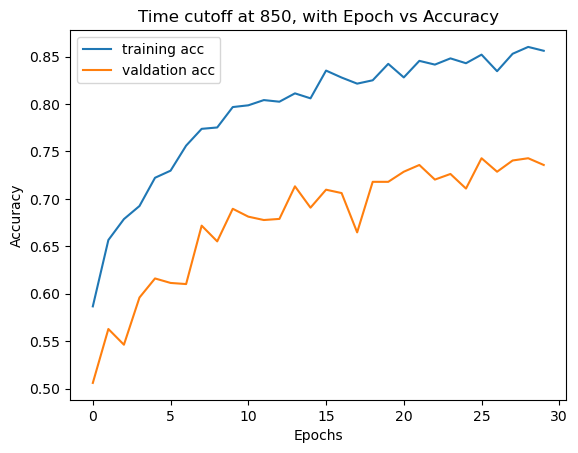

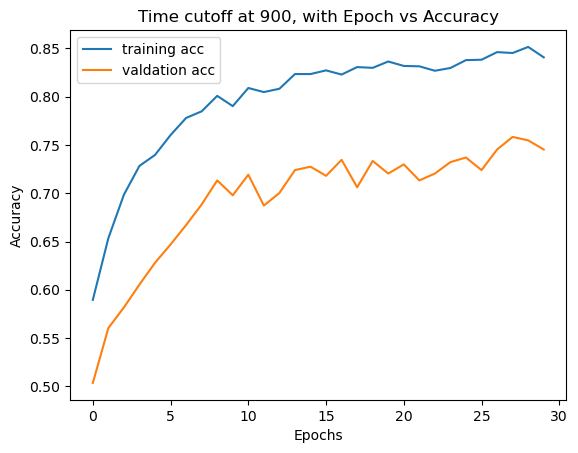

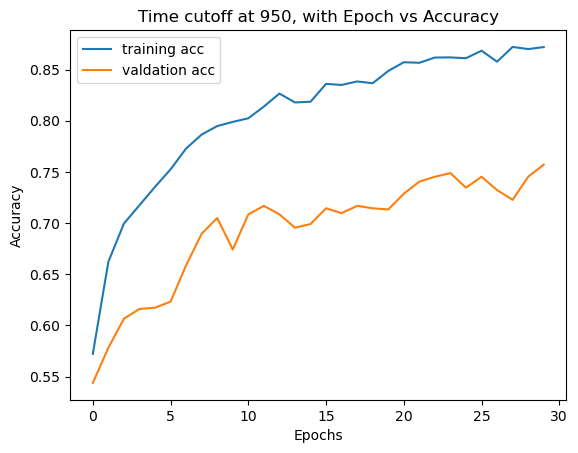

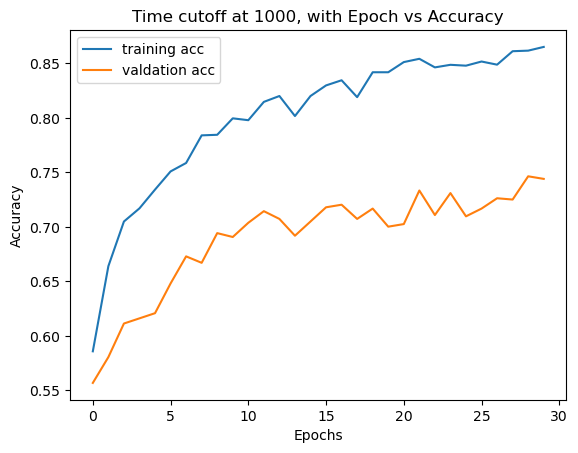

In [3]:
from matplotlib import pyplot as plt
for i in sorted(all_result.keys()):
    plt.plot(all_result[i]["train_acc_history"], label='training acc')
    plt.plot(all_result[i]["val_acc_history"], label='valdation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Time cutoff at " + str(i) + ", with Epoch vs Accuracy")
    plt.legend()
    plt.show()

### Cutoff vs max validation accuracy

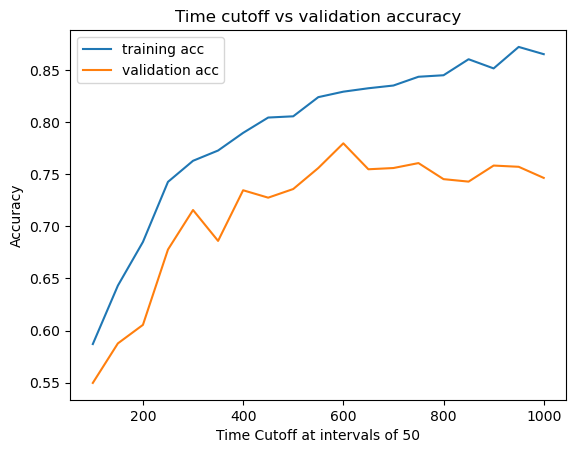

In [4]:
from matplotlib import pyplot as plt

max_val = []
max_train = []

for i in sorted(all_result.keys()):
    max_val.append(max(all_result[i]["val_acc_history"]))
    max_train.append(max(all_result[i]["train_acc_history"]))
    from tabulate import tabulate
print(tabulate([['Alice', 24], ['Bob', 19]], headers=['Name', 'Age']))

plt.plot(sorted(all_result.keys()), max_train, label='training acc')
plt.plot(sorted(all_result.keys()), max_val, label='validation acc')
plt.xlabel('Time Cutoff at intervals of 50')
plt.ylabel('Accuracy')
plt.title("Time cutoff vs validation accuracy")
plt.legend()
plt.show()

### Tabular Visualization

In [12]:
from texttable import Texttable
t = Texttable()
res = [['Time Cutoff', 'Max Val Acc (epoch granularity)', 'Max Train Acc (epoch granularity)', 'Min Val Acc (epoch granularity)', 'Min Train Acc (epoch granularity)']]
for i in sorted(all_result.keys()):
    res.append([str(i), max(all_result[i]["val_acc_history"]),
                max(all_result[i]["train_acc_history"]),
                min(all_result[i]["val_acc_history"]),
                min(all_result[i]["train_acc_history"])
               ])
t.add_rows(res)
print(t.draw())

+-------------+----------------+---------------+---------------+---------------+
| Time Cutoff |  Max Val Acc   | Max Train Acc |  Min Val Acc  | Min Train Acc |
|             |     (epoch     |    (epoch     |    (epoch     |    (epoch     |
|             |  granularity)  | granularity)  | granularity)  | granularity)  |
+=============+================+===============+===============+===============+
| 100         | 0.550          | 0.587         | 0.382         | 0.407         |
+-------------+----------------+---------------+---------------+---------------+
| 150         | 0.588          | 0.643         | 0.415         | 0.439         |
+-------------+----------------+---------------+---------------+---------------+
| 200         | 0.605          | 0.685         | 0.408         | 0.477         |
+-------------+----------------+---------------+---------------+---------------+
| 250         | 0.678          | 0.743         | 0.418         | 0.511         |
+-------------+-------------